In [1]:
import sys
sys.path.append( '../relative_fitness_mechanisms/' )
import plot_utils
from latent_immunity_relative_fitness import RelativeFitnessDR, LatentRW, LatentSplineRW

/Users/marlinfiggins/Library/Caches/pypoetry/virtualenvs/relative-fitness-mechanisms-KI8Zm32G-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib as mpl
mpl.rcParams["xtick.labelsize"] = 18

In [3]:
import jax
from jax import jit, lax
from functools import partial
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import evofr as ef

import matplotlib.dates as mdates

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable

from sklearn.decomposition import PCA
from sklearn.manifold import MDS

In [4]:
#raw_seq = pd.read_csv("../../evofr/test/testing_data/mlr-variant-counts.tsv", sep="\t")
#raw_seq = raw_seq[raw_seq.location == "City0"]
#data = ef.VariantFrequencies(raw_seq, pivot="C")

In [5]:
#raw_seq = pd.read_csv("../../rt-from-frequency-dynamics/data/variants-us/variants-us_location-variant-sequence-counts.tsv", sep="\t")
#raw_seq
#data = ef.VariantFrequencies(raw_seq)
#data = ef.HierFrequencies(raw_seq, group="location")

In [6]:
#raw_seq = pd.read_csv("../../HHMI_poster/data/seq_counts_nextstrain_clades_usa.tsv.gz", sep="\t").rename(columns={"clade": "variant"})
#raw_seq = pd.read_csv("../../HHMI_poster/data/seq_counts_pango_lineages_usa.tsv.gz", sep="\t").rename(columns={"clade": "variant"})

raw_seq = pd.read_csv("../data/pango-lineage/collapsed-sequence-counts-global.tsv", sep="\t")
#TODO: Collapsing on pango data

In [7]:
date_start = "2023-03-01"
date_end = "2024-06-01"

raw_seq = raw_seq[raw_seq.date < date_end].copy()
raw_seq = raw_seq[raw_seq.date > date_start].copy()

data = ef.HierFrequencies(raw_seq, group="location")

In [8]:
unique_variants = raw_seq.variant.unique()
print(f"There are {len(unique_variants)} variants")
print(unique_variants)

unique_locations = raw_seq.location.unique()
print(f"There are {len(unique_locations)} locations")
print(unique_locations)

There are 53 variants
['B.1.1.529' 'BA.2.86.1' 'BA.5.2' 'BA.5.2.1' 'BN.1' 'BQ.1.1' 'CH.1.1'
 'CH.1.1.1' 'EG.1' 'EG.5.1' 'EG.5.1.1' 'EG.5.1.3' 'EG.5.1.4' 'EG.5.1.6'
 'FL.1.5.1' 'FL.2' 'FL.4' 'FU.1' 'GE.1' 'GJ.1.2' 'GK.1.1' 'HF.1' 'HK.3'
 'HK.3.2' 'HV.1' 'JD.1.1' 'JG.3' 'JN.1' 'JN.1.1' 'JN.1.11.1' 'JN.1.4'
 'JN.1.4.5' 'JN.1.7' 'JN.1.8' 'KP.2' 'KP.3' 'XBB.1' 'XBB.1.16'
 'XBB.1.16.1' 'XBB.1.16.11' 'XBB.1.16.6' 'XBB.1.18.1' 'XBB.1.22.1'
 'XBB.1.5' 'XBB.1.5.15' 'XBB.1.5.70' 'XBB.1.9.1' 'XBB.1.9.2' 'XBB.2.3'
 'XBB.2.3.11' 'XBB.2.3.2' 'XBC.1' 'other']
There are 18 locations
['Australia' 'Brazil' 'Canada' 'China' 'France' 'Germany' 'Japan'
 'New Zealand' 'Russia' 'Singapore' 'South Korea' 'Sweden' 'Thailand'
 'USA' 'United Kingdom' 'Ireland' 'Spain' 'Taiwan']


In [9]:
from evofr.plotting import FrequencyPlot, GrowthAdvantagePlot, TimeVaryingPlot, PatchLegend

In [10]:
infer = False
load = True

In [11]:
# Finding proper latent dim
latent_dim_candidates = np.arange(2, 13)
num_candidates = len(latent_dim_candidates)
posteriors = {}
if infer:
    for i, latent_dim in enumerate(latent_dim_candidates):
        print(f"Fitting K = {latent_dim}. ({i+1}/{num_candidates})")
        phi_model = LatentSplineRW(ef.Spline(order=4, k=6))
        model = RelativeFitnessDR(dim=latent_dim, phi_model=phi_model, hier=True)
        #inference_method = ef.InferNUTS(num_samples=500, num_warmup=500)
        inference_method = ef.InferMAP(lr=4e-4, iters=30_000)
        posteriors[latent_dim] = inference_method.fit(model, data=data)
        posteriors[latent_dim].save_posterior(f"../results/posteriors/latent-factor-analysis/latent_factor_{latent_dim}.pkl")

In [12]:
posteriors = {}
if load:
    for i, latent_dim in enumerate(latent_dim_candidates):
        posteriors[latent_dim] = ef.PosteriorHandler(data=data)
        posteriors[latent_dim].load_posterior(f"../results/posteriors/latent-factor-analysis/latent_factor_{latent_dim}.pkl")

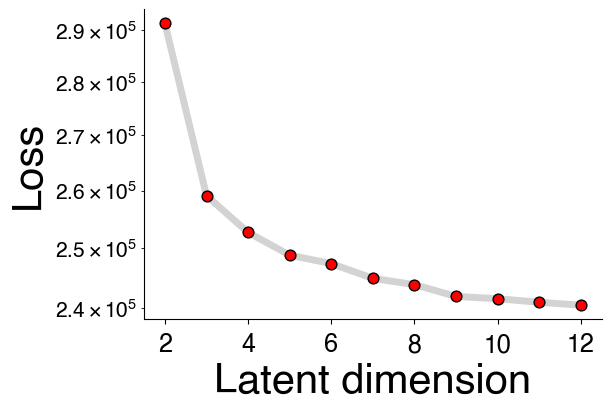

In [13]:
# Plot final losses by model
if "losses" in posteriors[latent_dim_candidates[0]].samples.keys():
    fig = plt.figure(figsize=(6., 4.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=1, nrows=1)
    ax = fig.add_subplot(spec[0])
    
    losses = {dim: post.samples["losses"][-1] for dim, post in posteriors.items()}
    ax.plot(losses.keys(), losses.values(), zorder=-1, color="lightgrey")
    ax.scatter(losses.keys(), losses.values(), ec="k", s=60, color="red")
    ax.set_yscale("log")
    ax.set_ylabel("Loss")
    ax.set_xlabel("Latent dimension")
    ax.set_xticks([2,4,6, 8, 10, 12])
    
#    fig.savefig("../manuscript/supplementary_figures/loss_by_latent_dimension.png")

In [14]:
chosen_latent = 8
posterior = posteriors[chosen_latent]

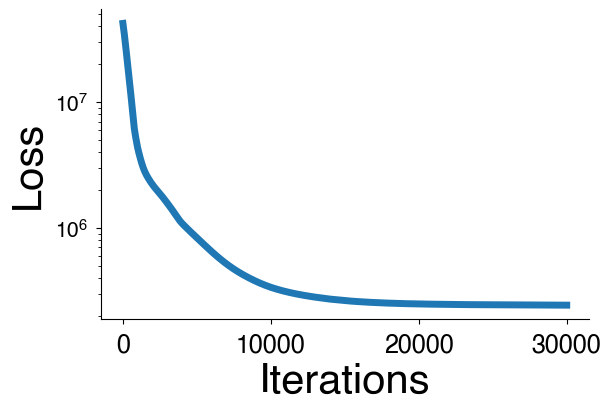

In [15]:
if "losses" in posterior.samples.keys():
    fig = plt.figure(figsize=(6., 4.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=1, nrows=1)
    ax = fig.add_subplot(spec[0])
    ax.plot(posterior.samples["losses"])
    ax.set_yscale("log")
    ax.set_ylabel("Loss")
    ax.set_xlabel("Iterations")

In [16]:
def get_groups(samples, sites, group):
    samples_group = dict()
    for site in sites:
        samples_group[site] = samples[site][..., group] 
    return samples_group

def get_posterior(posterior, sites, group):
    _samples = get_groups(posterior.samples, sites, group)
    _data = posterior.data.groups[group]
    return ef.PosteriorHandler(samples=_samples, data=_data)

In [17]:
eta = posterior.samples["eta"][0,:,:]
eta_transformed = MDS(normalized_stress="auto").fit_transform(eta)

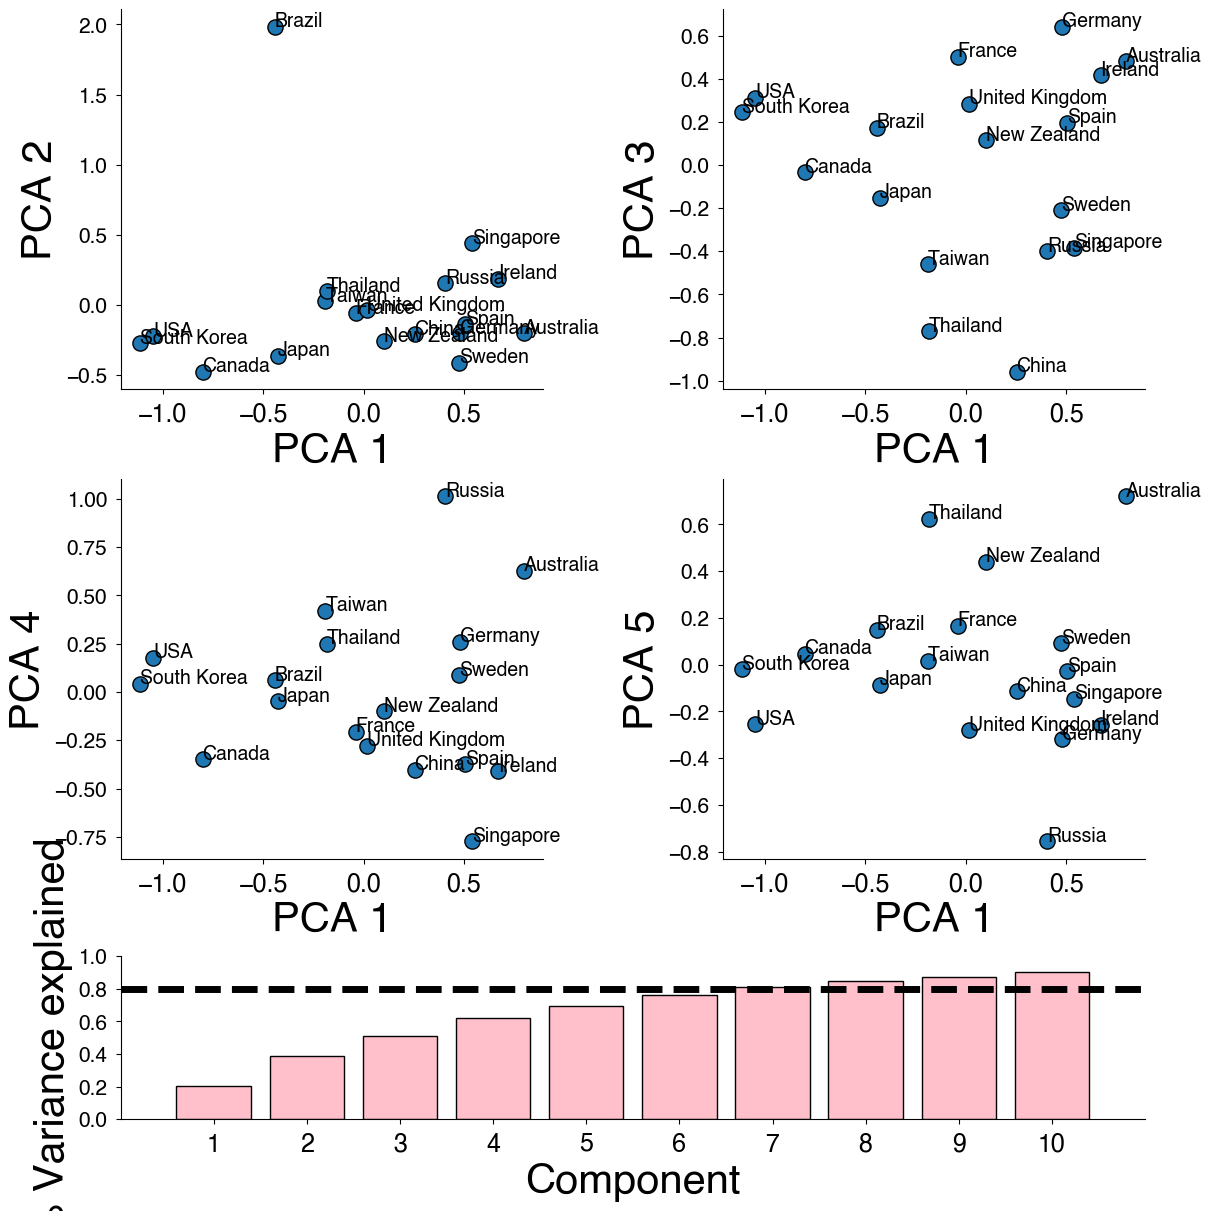

In [18]:

def plot_geo_phi_embedding(posterior):
    fig = plt.figure(figsize=(12., 12.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=2, nrows=3, height_ratios=[0.7, 0.7, 0.3])

    ax_explained = fig.add_subplot(spec[-2:])

    phi = posterior.samples["phi"][0, ...]
    
    # We want to collapse first three columns basically
    new_shape = (-1, phi.shape[-1])
    long_phi = np.reshape(phi, new_shape)
    
    pca = PCA(n_components=10)
    pca.fit(long_phi.T)
    
    # Plot locations
    phi_transformed = pca.transform(long_phi.T)
    def plot_pca_dims(ax, X_transformed, dim1, dim2):
        ax.scatter(X_transformed[:, dim1], X_transformed[:, dim2], ec="k", s=120)
        ax.set_xlabel(f"PCA {dim1+1}")
        ax.set_ylabel(f"PCA {dim2+1}")
        # Annotate
        for i, txt in enumerate(posterior.data.names):
            ax.annotate(txt, (X_transformed[i, dim1], X_transformed[i, dim2]), size=14, weight="bold")
        return None
    
    
    ax = fig.add_subplot(spec[0])
    plot_pca_dims(ax, phi_transformed, 0, 1)
    
    ax = fig.add_subplot(spec[1])
    plot_pca_dims(ax, phi_transformed, 0, 2)

    ax = fig.add_subplot(spec[2])
    plot_pca_dims(ax, phi_transformed, 0, 3)
    
    ax = fig.add_subplot(spec[3])
    plot_pca_dims(ax, phi_transformed, 0, 4)

    
    # Plot variance explained
    var_explained = np.cumsum(pca.explained_variance_ratio_)
    ax_explained.bar(np.arange(var_explained.shape[0])+1, var_explained, ec="k", color="pink")
    ax_explained.set_xticks(np.arange(var_explained.shape[0])+1)
    ax_explained.set_xlabel("Component")
    ax_explained.set_ylabel("% Variance explained")
    ax_explained.set_xlim((0, 11))
    ax_explained.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax_explained.axhline(y=0.8, color="k", linestyle="--")
    return None
    
    
plot_geo_phi_embedding(posterior)

# TODO: Color by continent and show as supplementary figure
# Which are the most anamolous
# Are there "natural" clusters here? What are they?
# Are these well-explained by air travel?

(18, 10)


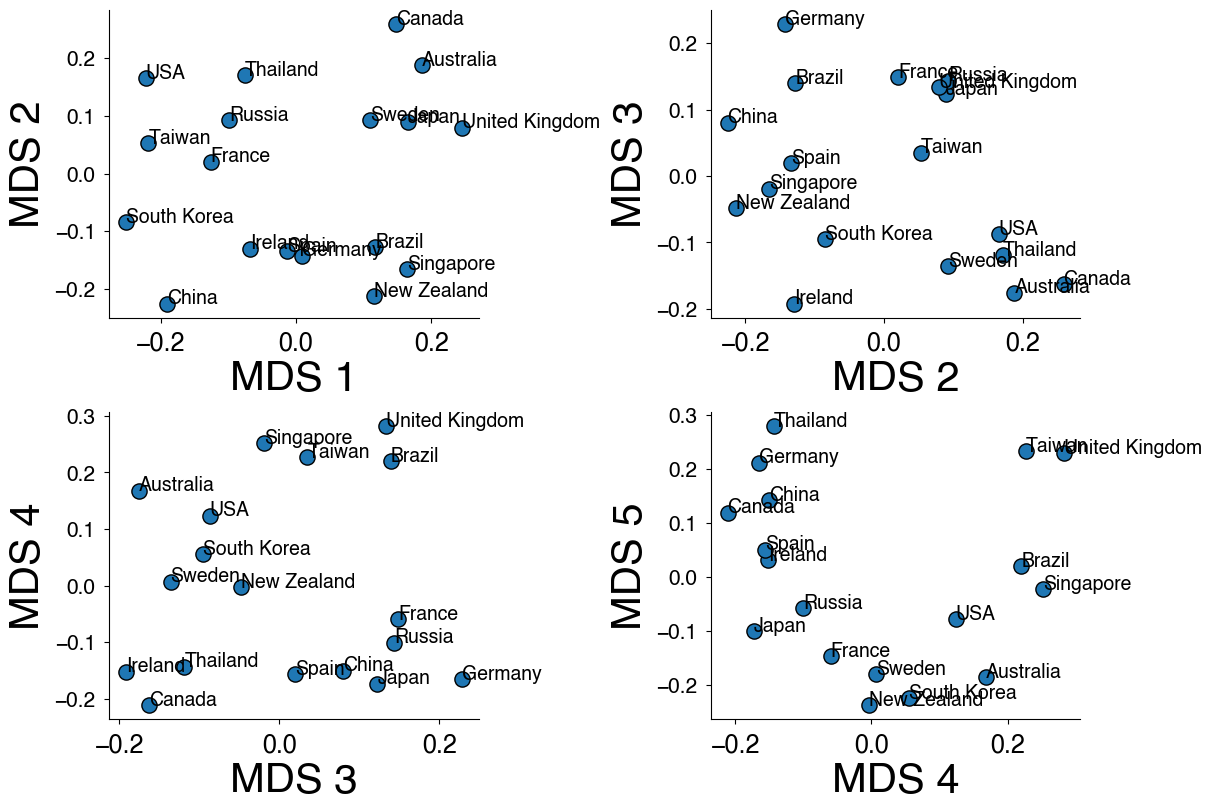

In [19]:
def plot_geo_phi_embedding(posterior):
    fig = plt.figure(figsize=(12., 8.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=2, nrows=2)
    phi = posterior.samples["phi"][0, ...]
    
    # We want to collapse first three columns basically
    new_shape = (-1, phi.shape[-1])
    long_phi = np.reshape(phi, new_shape)
    
    mds = MDS(10, normalized_stress=True, metric=False,random_state=12)
    phi_transformed = mds.fit_transform(long_phi.T)
    print(phi_transformed.shape)
    # Plot locations
    def plot_mds_dims(ax, X_transformed, dim1, dim2):
        ax.scatter(X_transformed[:, dim1], X_transformed[:, dim2], ec="k", s=120)
        ax.set_xlabel(f"MDS {dim1+1}")
        ax.set_ylabel(f"MDS {dim2+1}")
        # Annotate
        for i, txt in enumerate(posterior.data.names):
            ax.annotate(txt, (X_transformed[i, dim1], X_transformed[i, dim2]), size=14, weight="bold")
        return None
    
    
    ax = fig.add_subplot(spec[0])
    plot_mds_dims(ax, phi_transformed, 0, 1)
    ax = fig.add_subplot(spec[1])
    plot_mds_dims(ax, phi_transformed, 1, 2)
    ax = fig.add_subplot(spec[2])
    plot_mds_dims(ax, phi_transformed, 2, 3)
    ax = fig.add_subplot(spec[3])
    plot_mds_dims(ax, phi_transformed, 3, 4)

    return mds
    
    
mds = plot_geo_phi_embedding(posterior)

In [20]:
from pango_aliasor.aliasor import Aliasor

antigenic_map = pd.concat([pd.read_csv("../data/antigenic_map_data/immunized human.csv"), 
                           pd.read_csv("../data/antigenic_map_data/naive human.csv")])
antigenic_map.columns

# For each variant in posterior, check
# 1. if it was tested directly (ignore)
# 2. its parent was tested (consider renaming)
# 3. its parent is not already directly observed (do not rename)

remapping = {}
aliasor = Aliasor()
for var in posterior.data.var_names:
    parent = aliasor.parent(var)
    if (parent in antigenic_map.columns) and (var not in antigenic_map.columns) and (parent not in posterior.data.var_names):
        remapping[parent] = var

# For each variant in antigenic map, check
# 1. check whether we estimated pseudo-escape for its parent but not directly
# 2. check whether parent is directly observed (do not rename)
# 3. That we have not already renamed
# 4. Avoid long brannches -> avoid collapsing BA.1, BA.2, BA.5

for var in antigenic_map.columns:
    parent = aliasor.parent(var)
    if ((parent in posterior.data.var_names) 
        and (var not in posterior.data.var_names) 
        and (parent not in antigenic_map.columns)
        and (var not in remapping)
        and (parent not in ["B.1.1.529"])
       ):
        remapping[var] = parent

        
antigenic_map = antigenic_map.rename(columns=remapping) 

In [21]:
remapping

{'BA.2.86': 'BA.2.86.1',
 'BA.5': 'BA.5.2',
 'EG.5': 'EG.5.1',
 'BF.7': 'BA.5.2.1',
 'HK.3.1': 'HK.3',
 'JG.3.2': 'JG.3'}

In [22]:
antigenic_map = antigenic_map.rename(columns=remapping) 

In [23]:
#antigenic_map_melt = antigenic_map.melt(["id", "group"], var_name="strain", value_name="NT50")

In [24]:
#antigenic_map_melt.strain.unique()

In [25]:
def compute_log2_distances(X):
    X_transformed = np.log2(X.values)
    return np.sqrt(np.sum(np.square(X_transformed.T[..., None] - X_transformed), axis=1))

def create_titer_distance_df(X):
    rows = []
    for i, v in enumerate(X.columns):
        for j, u in enumerate(X.columns[:(i+1)]):
            rows.append({"variant_1": v, "variant_2": u, "titer_distance": distances[i, j]})
    return pd.DataFrame(rows)

X = antigenic_map.drop(columns=["id", "group"])
distances = compute_log2_distances(X)
distances_df = create_titer_distance_df(X)

In [26]:
X

D614G  Beta  BA.1  BA.2  BA.2.75  CH.1.1  BA.5.2  BA.5.2.1  BQ.1.1  \
0    1381   714  2235  8310     2671     559    4119      2680     713   
1     463   671  1042   829      537     135    2103       544     178   
2    4862  1122  2805  7525      374     300    3650      2455    1885   
3     310   256  1425  2028      511     273    3710      1799     622   
4     577   568  1220   699      639      82    1047       283     135   
..    ...   ...   ...   ...      ...     ...     ...       ...     ...   
23    438   294   114    88      100      20      74        39      20   
24     20    20    20   214       44      27     196       104     128   
25     20    20    20   146       54      26     190       110      76   
26     34    28    30   184       80      33     202       144     108   
27     20    20    20    54       54      20      76        50      52   

    XBB.1.5  EG.5.1  HV.1  HK.3  JD.1.1  JG.3  BA.2.86.1  JN.1  BA.2.87.1  \
0       341     327   475   250     170   245       1072   939        195   
1       462     271   445   365     321   200        735   284        107   
2       699     485   587   283     175   294       1410   866        455   
3       387     480   655   243     135   153        801   771        151   
4       257     203   257   210     173   147        380   259         65   
..      ...     ...   ...   ...     ...   ...        ...   ...        ...   
23       20      20    20    20      20    20         31    27         20   
24       44      26    44    30      22    23         20    20         20   
25       34      42    48    20      20    20         72    62         20   
26       36      28    40    26      20    22         86    48         26   
27       20      20    20    20      20    20         42    31         20   

    JN.1.23  KP.3  
0       461   399  
1       257   146  
2       411   252  
3       359   395  
4       222   188  
..      ...   ...  
23       28    20  
24       20    20  
25       48    20  
26       34    20  
27       29    20  

[68 rows x 20 columns]

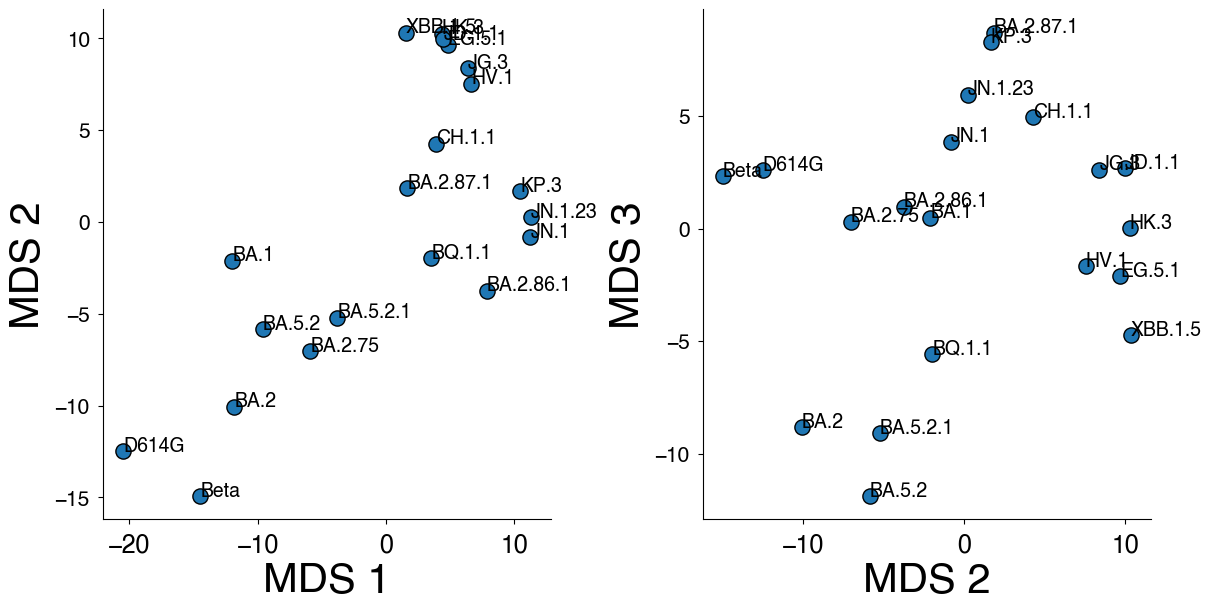

In [27]:
fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=1)

def plot_mds_dims(ax, X_transformed, dim1, dim2):
        ax.scatter(X_transformed[:, dim1], X_transformed[:, dim2], ec="k", s=120)
        ax.set_xlabel(f"MDS {dim1+1}")
        ax.set_ylabel(f"MDS {dim2+1}")
        # Annotate
        for i, txt in enumerate(X.columns):
            ax.annotate(txt, (X_transformed[i, dim1], X_transformed[i, dim2]), size=14, weight="bold")
        return None

mds = MDS(n_components=3, normalized_stress="auto", random_state=12)
X_transformed = mds.fit_transform(np.log2(X.values.T))

ax = fig.add_subplot(spec[0])
plot_mds_dims(ax, X_transformed, 0, 1 )
ax = fig.add_subplot(spec[1])
plot_mds_dims(ax, X_transformed, 1, 2)

In [28]:
common_variants = [v for v in posterior.data.var_names if v in X.columns]

In [29]:
common_variants

['BA.2.86.1',
 'BA.5.2',
 'BA.5.2.1',
 'BQ.1.1',
 'CH.1.1',
 'EG.5.1',
 'HK.3',
 'HV.1',
 'JD.1.1',
 'JG.3',
 'JN.1',
 'KP.3',
 'XBB.1.5']

In [30]:
[v for v in posterior.data.var_names]

['B.1.1.529',
 'BA.2.86.1',
 'BA.5.2',
 'BA.5.2.1',
 'BN.1',
 'BQ.1.1',
 'CH.1.1',
 'CH.1.1.1',
 'EG.1',
 'EG.5.1',
 'EG.5.1.1',
 'EG.5.1.3',
 'EG.5.1.4',
 'EG.5.1.6',
 'FL.1.5.1',
 'FL.2',
 'FL.4',
 'FU.1',
 'GE.1',
 'GJ.1.2',
 'GK.1.1',
 'HF.1',
 'HK.3',
 'HK.3.2',
 'HV.1',
 'JD.1.1',
 'JG.3',
 'JN.1',
 'JN.1.1',
 'JN.1.11.1',
 'JN.1.4',
 'JN.1.4.5',
 'JN.1.7',
 'JN.1.8',
 'KP.2',
 'KP.3',
 'XBB.1',
 'XBB.1.16',
 'XBB.1.16.1',
 'XBB.1.16.11',
 'XBB.1.16.6',
 'XBB.1.18.1',
 'XBB.1.22.1',
 'XBB.1.5',
 'XBB.1.5.15',
 'XBB.1.5.70',
 'XBB.1.9.1',
 'XBB.1.9.2',
 'XBB.2.3',
 'XBB.2.3.11',
 'XBB.2.3.2',
 'XBC.1',
 'other']

In [31]:
np.sort(distances_df.variant_1.unique())

array(['BA.1', 'BA.2', 'BA.2.75', 'BA.2.86.1', 'BA.2.87.1', 'BA.5.2',
       'BA.5.2.1', 'BQ.1.1', 'Beta', 'CH.1.1', 'D614G', 'EG.5.1', 'HK.3',
       'HV.1', 'JD.1.1', 'JG.3', 'JN.1', 'JN.1.23', 'KP.3', 'XBB.1.5'],
      dtype=object)

Text(0, 0.5, 'log2 Human NT50 Titer Distance')

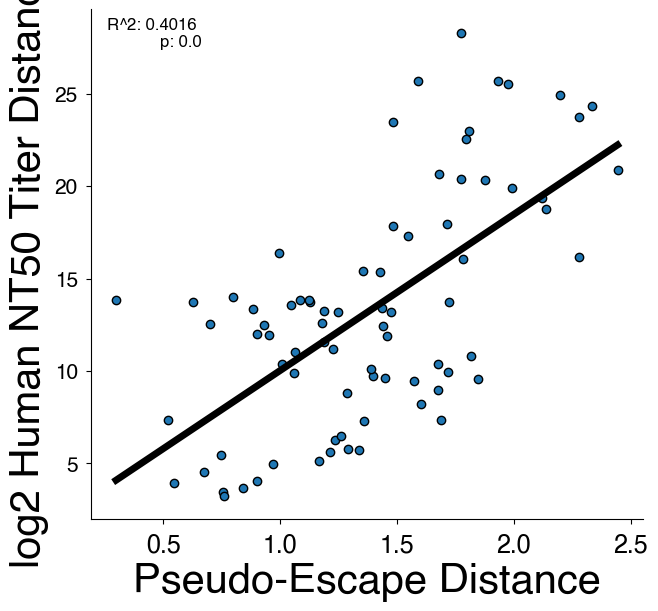

In [32]:
from scipy import stats

fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
spec = fig.add_gridspec(1,2)
ax = fig.add_subplot(spec[0])

def get_and_add_distances(post, _distance_df, randomize=False):
    distance_df = _distance_df.copy()
    
    ## Prepping data and labels
    eta = post.samples["eta"][0, :-1, :] # Remove other
    n_vars, n_comps = eta.shape
    
    if randomize:
        perm = np.random.permutation(n_vars)
        eta = eta[perm, :]

    eta_distances = jnp.sqrt(jnp.sum(jnp.square(eta[..., None] - eta.T), axis=1))
    var_names = post.data.var_names
    var_to_index = {v: i for i, v in enumerate(var_names)}        

    def add_latent_distance(row):
        if row["variant_1"] in common_variants and row["variant_2"] in common_variants:
            return float(eta_distances[var_to_index[row["variant_1"]], var_to_index[row["variant_2"]]])
        else:
            return np.nan
        
    distance_df["latent_distance"] = distance_df.apply(add_latent_distance, axis=1)
    return distance_df

X = antigenic_map.drop(columns=["id", "group"])
distances = compute_log2_distances(X)
distances_df = create_titer_distance_df(X)
distances_df = get_and_add_distances(posteriors[chosen_latent], distances_df)
distances_df = distances_df[distances_df.variant_1 != distances_df.variant_2]

# Fit linear regression
def fit_linear(col1, col2):
    x, y = distances_df[col1], distances_df[col2]
    is_finite = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[is_finite], y[is_finite]
    slope, intercept, r, p, se = stats.linregress(x, y)      
    xs = np.linspace(np.min(x), np.max(x), 20)
    ys = intercept + slope * xs
    return xs, ys, r, p

x_col, y_col =  "latent_distance", "titer_distance"
x, y = distances_df[x_col], distances_df[y_col]
ax.scatter(x, y, ec="k")       

# Fit linear regression between two variables
xs, ys, r, p = fit_linear(x_col, y_col)
ax.plot(xs, ys, color="k")

# Add regression statistics
ax.text(0.2, 0.985, f'R^2: {(r ** 2).round(4)} \np: {p.round(5)}',
        horizontalalignment='right',
        verticalalignment='top',
        transform=ax.transAxes)
ax.set_xlabel("Pseudo-Escape Distance")
ax.set_ylabel("log2 Human NT50 Titer Distance")


In [33]:
# Let's boostrap the correlation and R^2 here
import numpy as np
import pandas as pd

def bootstrap_regression(n_bootstrap, randomize=True):
    x_col, y_col =  "latent_distance", "titer_distance"
    x, y = distances_df[x_col], distances_df[y_col]

    r2s = []
    rs = []
    ps = []
    expected = []
    
    def fit_linear(col1, col2):
        x, y = distances_df[col1], distances_df[col2]
        is_finite = ~np.isnan(x) & ~np.isnan(y)
        
        # Boostrap for present data
        n_finite = np.sum(is_finite)
        sample = np.random.choice(n_finite, n_finite, replace=True)
                
        # Fit regression
        x, y = x[is_finite].values[sample], y[is_finite].values[sample]
        slope, intercept, r, p, se = stats.linregress(x, y)      
        xs = np.linspace(np.min(x), np.max(x), 20)
        ys = intercept + slope * xs
        return xs, ys, r, p

    
    for _ in range(n_bootstrap):
        # Fit linear regression
        xs, ys, r, p = fit_linear(x_col, y_col) 
        
        expected.append((xs,ys))
        r2s.append(r**2)
        rs.append(r)
        ps.append(p)
    return r2s, rs, ps, expected

# Example usage
r2_bootstrap, r_bootstrap, p_bootstrap, expected_bootstrap = bootstrap_regression(n_bootstrap=1000)

1000


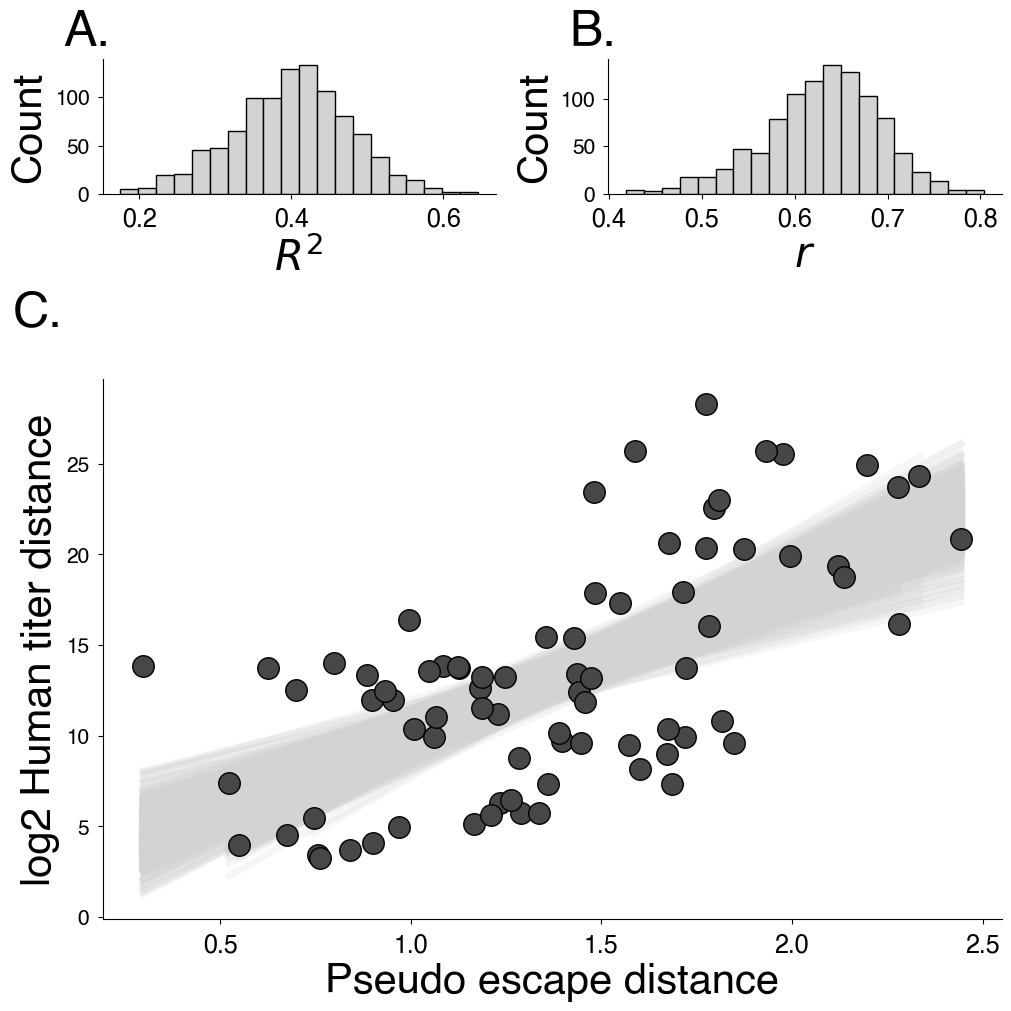

In [34]:
fig = plt.figure(figsize=(10., 10.), constrained_layout=True)
spec = fig.add_gridspec(2, 2, height_ratios=[0.2, 0.8])

# Bootstrapped R^2
ax_r2 = fig.add_subplot(spec[0])
ax_r2.hist(r2_bootstrap, color="lightgrey", ec="k", bins=20)
ax_r2.set_xlabel(r"$R^2$")
ax_r2.set_ylabel("Count")

# Bootrapped r
ax_r = fig.add_subplot(spec[1])
ax_r.hist(r_bootstrap, color="lightgrey", ec="k", bins=20)
ax_r.set_xlabel(r"$r$")
ax_r.set_ylabel("Count")
print((np.array(r_bootstrap) > 0).sum())
ax_expected = fig.add_subplot(spec[1, :])
x_col, y_col =  "latent_distance", "titer_distance"
x, y = distances_df[x_col], distances_df[y_col]
for xs, ys in expected_bootstrap:
    ax_expected.plot(xs, ys, alpha=0.2, color="lightgrey", zorder=-1)       
ax_expected.scatter(x, y, ec="k", color="#474747", s=240)      

ax_expected.set_xlabel("Pseudo escape distance")
ax_expected.set_ylabel("log2 Human titer distance")

# Add labels
ax_labels = ["A", "B", "C"] 

for ax, ax_label in zip([ax_r2, ax_r, ax_expected], ax_labels):
    ax.text(-0.1, 1.1, ax_label + ".", transform=ax.transAxes, size=36, weight='bold')

#fig.savefig("../manuscript/supplementary_figures/pseudo_escape_titer_correlation_bootstrap.png")

In [35]:
# Let's boostrap the correlation and R^2 here
import numpy as np
import pandas as pd

def bootstrap_regression_randomized(n_bootstrap):
    x_col, y_col =  "latent_distance", "titer_distance"
    
    X = antigenic_map.drop(columns=["id", "group"])
    distances = compute_log2_distances(X)
    distances_df_base = create_titer_distance_df(X)
    
    r2s = []
    rs = []
    ps = []
    expected = []
    
    def fit_linear(col1, col2):
        x, y = distances_df[col1], distances_df[col2]
        is_finite = ~np.isnan(x) & ~np.isnan(y)
        
        # Boostrap for present data
        n_finite = np.sum(is_finite)
        sample = np.random.choice(n_finite, n_finite, replace=True)
                
        # Fit regression
        x, y = x[is_finite].values[sample], y[is_finite].values[sample]
        slope, intercept, r, p, se = stats.linregress(x, y)      
        xs = np.linspace(np.min(x), np.max(x), 20)
        ys = intercept + slope * xs
        return xs, ys, r, p

    
    for _ in range(n_bootstrap):
        distances_df = get_and_add_distances(posteriors[chosen_latent], distances_df_base, randomize=True)
        distances_df = distances_df[distances_df.variant_1 != distances_df.variant_2]

        # Fit linear regression
        xs, ys, r, p = fit_linear(x_col, y_col) 
        
        expected.append((xs,ys))
        r2s.append(r**2)
        rs.append(r)
        ps.append(p)
    return r2s, rs, ps, expected

# Example usage
r2_bootstrap_rand, r_bootstrap_rand, p_bootstrap_rand, expected_bootstrap_rand = bootstrap_regression_randomized(n_bootstrap=1000)

0.001
0.001


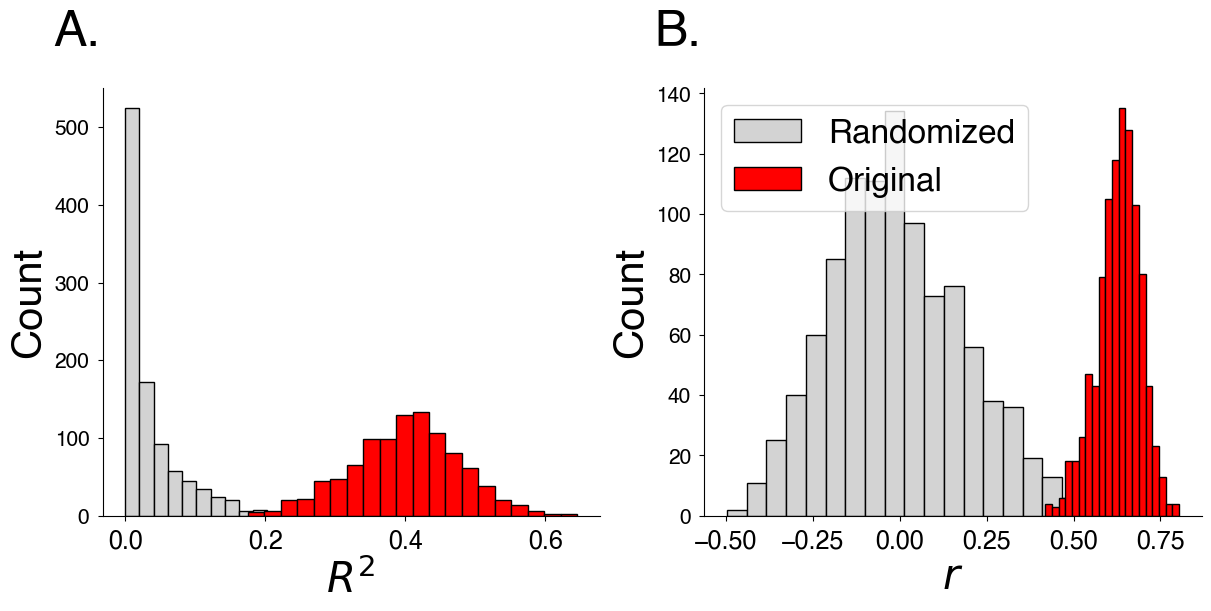

In [36]:
fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
spec = fig.add_gridspec(1, 2)

# Bootstrapped R^2
ax_r2 = fig.add_subplot(spec[0])
ax_r2.hist(r2_bootstrap_rand, color="lightgrey", ec="k", bins=20)
ax_r2.hist(r2_bootstrap, color="red", ec="k", bins=20)
print((np.array(r2_bootstrap_rand) > r ** 2).mean())

ax_r2.set_xlabel(r"$R^2$")
ax_r2.set_ylabel("Count")

# Bootrapped r
ax_r = fig.add_subplot(spec[1])
ax_r.hist(r_bootstrap_rand, color="lightgrey", ec="k", bins=20, label="Randomized")
ax_r.hist(r_bootstrap, color="red", ec="k", bins=20, label="Original")
print((np.array(r_bootstrap_rand) > r).mean())

ax_r.set_xlabel(r"$r$")
ax_r.set_ylabel("Count")

ax_r.legend()

# Add labels
ax_labels = ["A", "B"] 

for ax, ax_label in zip([ax_r2, ax_r], ax_labels):
    ax.text(-0.1, 1.1, ax_label + ".", transform=ax.transAxes, size=36, weight='bold')

In [37]:
(np.array(r_bootstrap) > 0).sum()

1000

In [38]:
clade_definitions = [
    {
        "clade": "24B",
        "display_name": "24B (JN.1.11.1)",
        "defining_lineage": "JN.1.11.1",
        "color": '#DC2F24'
    },
    {
        "clade": "24A",
        "display_name": "24A (JN.1)",
        "defining_lineage": "JN.1",
        "color": '#E4632E'
    },
    {
        "clade": "23I",
        "display_name": "23I (BA.2.86)",
        "defining_lineage": "BA.2.86",
        "color": '#E69136'
    },
    {
        "clade": "23H",
        "display_name": "23H (HK.3)",
        "defining_lineage": "HK.3",
        "color": '#D9AD3D'
    },
    {
        "clade": "23G",
        "display_name": "23G (XBB.1.5.70)",
        "defining_lineage": "XBB.1.5.70",
        "color": '#C1BA47'
    },
    {
        "clade": "23F",
        "display_name": "23F (EG.5.1)",
        "defining_lineage": "EG.5.1",
        "color": '#A2BE57'
    },
    {
        "clade": "23E",
        "display_name": "23E (XBB.2.3)",
        "defining_lineage": "XBB.2.3",
        "color": '#83BA70'
    },
    {
        "clade": "23D",
        "display_name": "23D (XBB.1.9)",
        "defining_lineage": "XBB.1.9",
        "color": '#69B091'
    },
    {
        "clade": "23C",
        "display_name": "23C (CH.1.1)",
        "defining_lineage": "CH.1.1",
        "color": '#549DB2'
    },
    {
        "clade": "23B",
        "display_name": "23B (XBB.1.16)",
        "defining_lineage": "XBB.1.16",
        "color": '#4580CA'
    },
    {
        "clade": "23A",
        "display_name": "23A (XBB.1.5)",
        "defining_lineage": "XBB.1.5",
        "color": '#462EB9'
    },
    {
        "clade": "22F",
        "display_name": "22F (XBB)",
        "defining_lineage": "XBB",
        "color": '#3E58CF'
    },
    {
        "clade": "22E",
        "display_name": "22E (BQ.1)",
        "defining_lineage": "BQ.1",
        "color": '#777777'
    },
    {
        "clade": "22D",
        "display_name": "22D (BA.2.75)",
        "defining_lineage": "BA.2.75",
        "color": '#777777'
    },
    {
        "clade": "22B",
        "display_name": "22B (BA.5)",
        "defining_lineage": "BA.5",
        "color": '#777777'
    },
    {
        "clade": "other",
        "display_name": "other",
        "defining_lineage": False,
        "color": '#777777'
    }
]

In [39]:
from pango_aliasor.aliasor import Aliasor
import colorsys

DEFAULT_CLADE_COLOR = '#777777'
def order_lineages(lineages, aliasor):
    """
    Order input lineages by using their full uncompressed lineage & converting to a sortable form
    e.g. BA.5  -> B.1.1.529.5  -> '  B/001/001/529/005'
         BA.16 -> B.1.1.529.16 -> '  B/001/001/529/016'
         so BA.5 is before BA.16
    """
    def _lineage_sortable(lineage):
        if lineage=='other':
            return "ZZZ"
        lin_full = aliasor.uncompress(lineage)
        return "/".join([(f"{x:>3}" if i==0 else f"{int(x):03}") for i,x in enumerate(lin_full.split('.'))])
    return sorted(lineages,key=_lineage_sortable)

def order_lineages_within_clade(lineages, aliasor, clade_map):
    """
    Order input lineages by their clades first and then by using their full uncompressed lineage,
    converting to a sortable form within each clade.

    Parameters:
    lineages (list of str): List of lineage names to be sorted.
    aliasor (object): An object with a method `uncompress` that converts compressed lineage names to full lineage names.
    clades (list of str): List of clade assignments corresponding to each lineage.

    Returns:
    list of str: Sorted list of lineage names.

    Example:
    >>> class Aliasor:
    ...     def uncompress(self, lineage):
    ...         return {"BA.5": "B.1.1.529.5", "BA.16": "B.1.1.529.16", "BA.2": "B.1.1.529.2"}[lineage]
    >>> aliasor = Aliasor()
    >>> lineages = ["BA.5", "BA.16", "BA.2"]
    >>> clades = ["Clade1", "Clade1", "Clade2"]
    >>> order_lineages(lineages, aliasor, clades)
    ['BA.5', 'BA.16', 'BA.2']
    """

    def _lineage_sortable(lineage):
        if lineage == 'other':
            return "ZZZ"
        lin_full = aliasor.uncompress(lineage)
        return "/".join([(f"{x:>3}" if i == 0 else f"{int(x):03}") for i, x in enumerate(lin_full.split('.'))])
    
    # Sort the lineages first by clade and then by the sortable form of the lineage
    return sorted(lineages, key=lambda lineage: (clade_map[lineage], _lineage_sortable(lineage)))

def lineage_to_clade(lineage, aliasor, fallback, clade_definitions):
    lineage_full = aliasor.uncompress(lineage)
    for clade_data in clade_definitions:
        if clade_data['clade']=='other':
            continue
        comparison_lineage = aliasor.uncompress(clade_data['defining_lineage'])
        if lineage_full == comparison_lineage or lineage_full.startswith(comparison_lineage + "."):
            return clade_data['clade']
    return fallback

def clade_colors(variants, clade_definitions):
    colors = {c['clade']: c['color'] for c in clade_definitions}
    missing = set()
    defs = []
    for v in variants:
        try:
            defs.append([v, colors[v]])
        except KeyError:
            if v!='other':
                missing.add(v)
                defs.append([v, DEFAULT_CLADE_COLOR])

    # TODO: Emit this to output file so it can be sent thru Slack notifications
    if len(missing) > 0:
        print(
            f"Missing definitions for the following clades: {', '.join(missing)}.",
            f"They have been assigned the default color {DEFAULT_CLADE_COLOR!r}"
        )

    return defs

def clade_display_names(variants, clade_definitions):
    display_names = {c['clade']: c['display_name'] for c in clade_definitions}
    return [[name, display_names[name] if name in display_names else name]
            for name in variants]

def colour_range(anchor, n):
    """
    Create a range of `n` colours centred around the provided `anchor`.
    This currently involves simple manipulations in HLS space, but
    the outputs aren't going to be as good as they could be if we did it in
    a perceptually uniform space (e.g lab space). For the purposes of this viz
    I don't think it's a dealbreaker, and in our current setup it's hard to use
    python libraries which aren't already available in our various runtimes.
    """
    anchor_rgb = tuple(int(anchor.lstrip('#')[i:i+2], 16) for i in (0, 2, 4))
    anchor_hls = colorsys.rgb_to_hls(*anchor_rgb)
    hrange = np.linspace(anchor_hls[0]*0.85, anchor_hls[0]*1.25, n)
    lrange = np.linspace(anchor_hls[1]*1.2, anchor_hls[1], n)
    srange = np.linspace(anchor_hls[2]*0.7, anchor_hls[2]*1.1, n)
    rgb_range = [colorsys.hls_to_rgb(*hls) for hls in zip(hrange, lrange, srange)]
    def clamp(x):
        return int(max(0, min(x, 255)))
    return [f"#{clamp(rgb[0]):02x}{clamp(rgb[1]):02x}{clamp(rgb[2]):02x}" for rgb in rgb_range]

def colourise(lineages, aliasor, clade_definitions):
    """
    Produces an array of arrays associating observed lineages with a colour hex. Example output:
        [
            ['XBB', '#ffffff'],
            ...
        ]
    """
    clades = {lineage: lineage_to_clade(lineage, aliasor, 'other', clade_definitions)
              for lineage in lineages}

    colours = []

    for clade in list(set(clades.values())):
        matching_lineages = [l for l in lineages if clades[l]==clade] # will be ordered
        print(f"{clade:<10}n={len(matching_lineages)} lineages")
        color_hex = [x['color'] for x in clade_definitions if x['clade']==clade][0]
        for pair in zip(matching_lineages, colour_range(color_hex, len(matching_lineages))):
            colours.append(pair)
    return colours

aliasor = Aliasor()
color_map = colourise(posterior.data.var_names, aliasor, clade_definitions)
color_map = {entry[0]: entry[1] for entry in color_map}
clade_map = {lineage: lineage_to_clade(lineage, aliasor, 'other', clade_definitions)
              for lineage in posterior.data.var_names}

24A       n=6 lineages
23G       n=2 lineages
23I       n=1 lineages
22B       n=2 lineages
23A       n=3 lineages
22F       n=3 lineages
22D       n=1 lineages
23D       n=6 lineages
23H       n=2 lineages
23E       n=5 lineages
23C       n=2 lineages
22E       n=1 lineages
23F       n=7 lineages
23B       n=6 lineages
24B       n=3 lineages
other     n=3 lineages


In [40]:
clade_color_map = clade_colors([c["clade"] for c in clade_definitions], clade_definitions)
clade_color_map = {c[0]: c[1] for c in clade_color_map}

In [41]:
aliasor.parent("KP.3")

'JN.1.11.1'

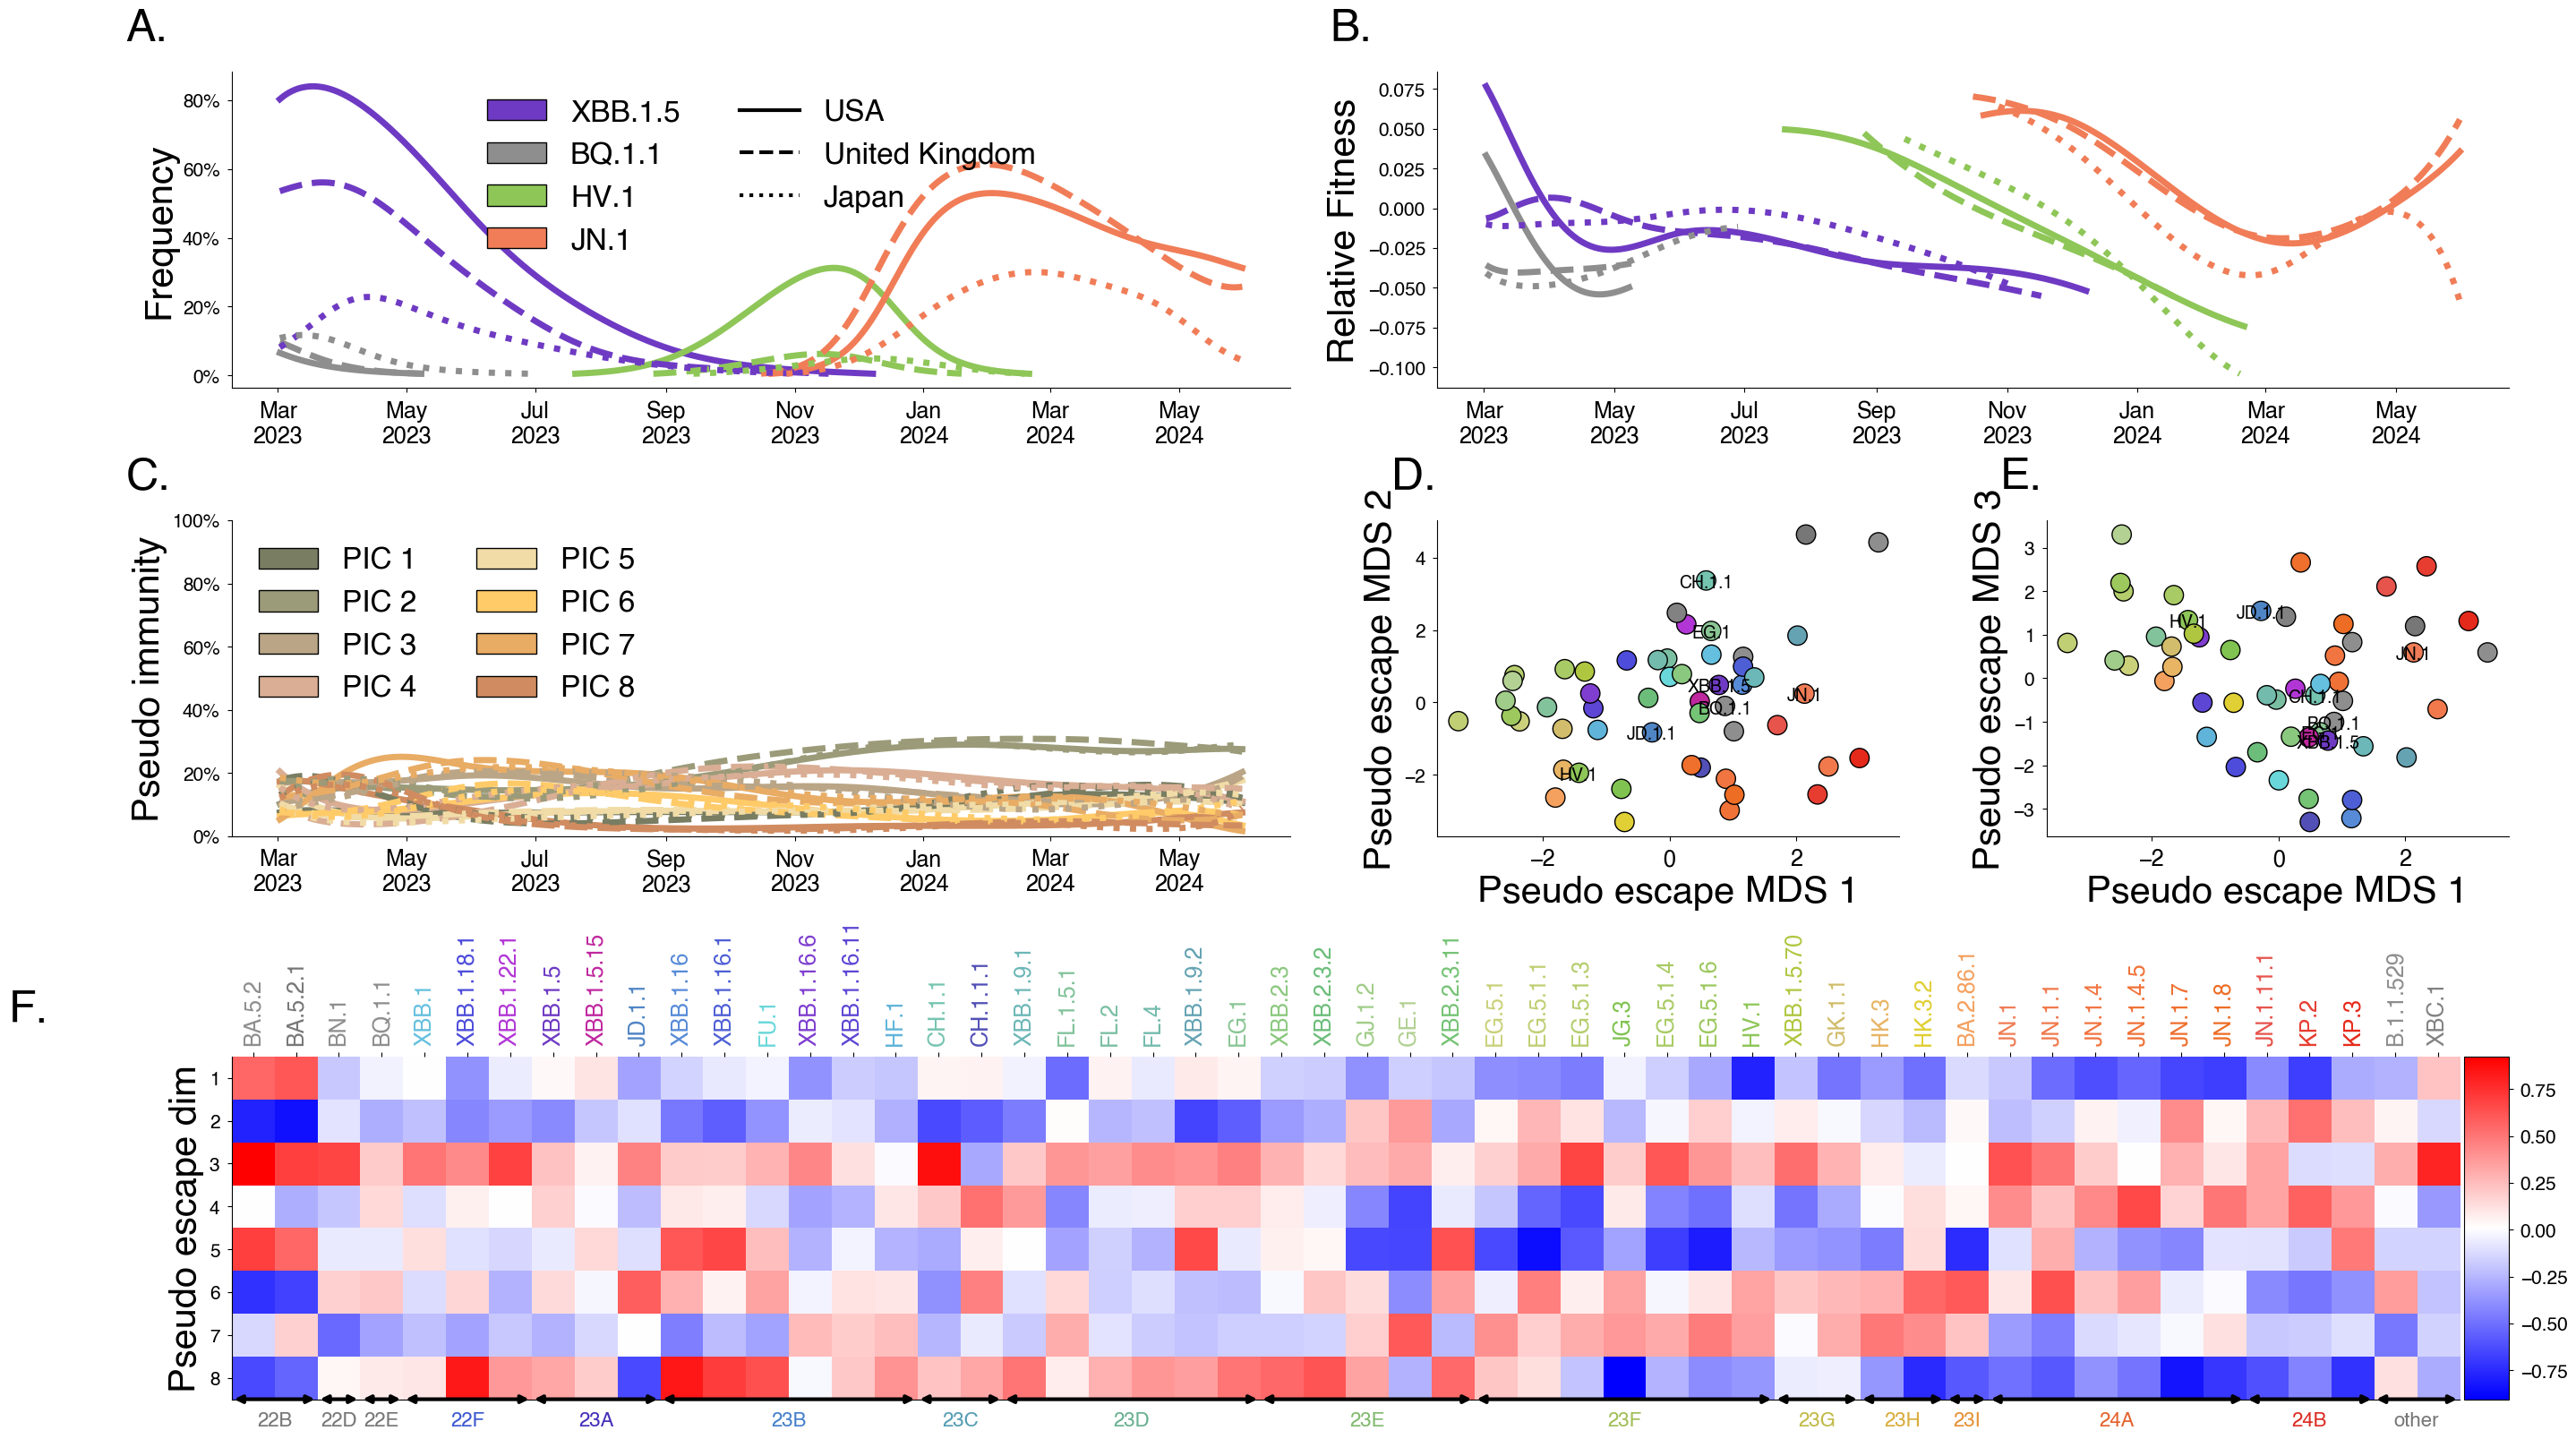

In [65]:
import matplotlib.dates as mdates

from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import PercentFormatter

def get_ordering(var_names):
    
    #reordered_names = order_lineages(var_names, aliasor)[:-1]
    reordered_names = order_lineages_within_clade(var_names, aliasor, clade_map)[:-1]
    reordered_clades = [clade_map[n] for n in reordered_names]

    reordered_idx = [var_names.index(r) for r in reordered_names]
    return reordered_idx, reordered_names, reordered_clades
    
# Fit linear regression
def fit_linear(col1, col2):
    x, y = distances_df[col1], distances_df[col2]
    is_finite = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[is_finite], y[is_finite]
    slope, intercept, r, p, se = stats.linregress(x, y)      
    xs = np.linspace(np.min(x), np.max(x), 20)
    ys = intercept + slope * xs
    return xs, ys, r, p

# Merge in latent distnances
def add_latent_distance(row, var_to_index, eta_distances):
    if row["variant_1"] in common_variants and row["variant_2"] in common_variants:
        return float(eta_distances[var_to_index[row["variant_1"]], var_to_index[row["variant_2"]]])
    else:
        return np.nan

def add_bracket(ax, start, end, label, y_offset=-0.1, height=0.02, **kwargs):
    """
    Add a bracket below the x-axis labels to group them.

    Parameters:
    ax : matplotlib.axes.Axes
        The axes to add the bracket to.
    start : int
        The starting index of the grouped labels.
    end : int
        The ending index of the grouped labels.
    label : str
        The label for the bracket.
    y_offset : float, optional
        The vertical offset for the bracket (default is -0.1).
    height : float, optional
        The height of the bracket (default is 0.02).
    kwargs : additional parameters for customization.
    """
    ax.annotate('', xy=(start, y_offset), xytext=(end, y_offset),
                arrowprops=dict(arrowstyle='<|-|>', lw=3.0, **kwargs))
    ax.text((start + end) * 0.5, y_offset - height, label, fontsize=16, color=clade_color_map[label],
            ha='center', va='center', **kwargs)
    
def add_clade_dividers(ax, reordered_clades, height=-0.4, y_offset=4.5):
    current_clade = reordered_clades[0]
    start = 0

    for i in range(1, len(reordered_clades)):
        if reordered_clades[i] != current_clade:
            add_bracket(ax, start-0.5, i-0.5, current_clade, y_offset=y_offset, height=height)
            current_clade = reordered_clades[i]
            start = i
            
    # Add bracket for the last group
    add_bracket(ax, start - 0.5, len(reordered_clades)-1 + 0.5, current_clade, y_offset=y_offset, height=height)
        
def summary_plot_hier(posterior, color_map,
                      label_variants=None, 
                      focal_variants=None,
                      focal_locations=None,
                      freq_thres = None,
                      plot_eta_time_mean=True):
    fig = plt.figure(figsize=(28., 16.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=4, nrows=3, height_ratios=[1.0, 1.0, 1.3])
    axes = []

    # Prep variants to plot in panels <A-B>
    if focal_variants is None:
        focal_variants = ["HK.3", "JN.1", "JN.1.1"]
    var_names = posterior.data.var_names
    var_idxs = [var_names.index(v) if v in var_names else None for v in focal_variants]
    
    # Prep locations to plot in panel <A-B-C>
    if focal_locations is None:
        focal_locations = ["USA", "United Kingdom", "Japan"]
    loc_names = posterior.data.names
    loc_idxs = [loc_names.index(loc) if loc in loc_names else None for loc in focal_locations]
    focal_style = {loc: ["-", "--", ":"][l] for l, loc in enumerate(focal_locations)}
    
    # Prep colors for immunity components in panel <C>
    immunity_colors = ["#f8f9fa","#e9ecef","#dee2e6","#ced4da","#adb5bd","#6c757d","#495057","#343a40","#212529"]
    immunity_colors = ["#797d62","#9b9b7a","#baa587","#d9ae94","#f1dca7","#ffcb69","#e8ac65","#d08c60","#b58463","#997b66", '#4D4D4D', '#B3B3B3']
    num_pseudo_immune = posterior.samples["phi"].shape[2]
    pic_color_map = {n: immunity_colors[n] for n in range(num_pseudo_immune)}
    
    # Prep locations to annoate in panel E
    if label_variants is None:
        label_variants = ["XBB.1.5", "EG.1", "HK.3", "JN.1", "JN.1.1"]

    # Get ordering and clades with pango_aliasor
    reordered_idx, reordered_names, reordered_clades = get_ordering(var_names)
    
    # Only plot variant at times above `freq_thres`
    if freq_thres is None:
        freq_thres = 0.001

    # Frequency
    ax = fig.add_subplot(spec[0, 0:2])
    for loc_idx, location in zip(loc_idxs, focal_locations):
        for var_idx, variant in zip(var_idxs, focal_variants):
            included = np.array((posterior.samples["freq"][0, :, var_idx, loc_idx] > freq_thres))
            ax.plot(np.array(posterior.data.dates)[included], posterior.samples["freq"][0, :, var_idx, loc_idx][included], color=color_map[variant], linestyle=focal_style[location])
    ax.set_ylabel("Frequency")
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axes.append(ax)
        
    # Add legend for focal variants
    variant_color_elements =  [Patch(facecolor=color_map[v], edgecolor='k', label=v) for v in focal_variants]
    location_style_elements = [Line2D([0], [0], color='k', lw=3, linestyle=focal_style[l], label=l) for l in focal_locations]
    legend_elements = variant_color_elements + location_style_elements
    ax.legend(handles=legend_elements, loc='best', ncols=2, frameon=False)

    # Relative Fitness
    ax = fig.add_subplot(spec[0, 2:4], sharex=ax)
    for loc_idx, location in zip(loc_idxs, focal_locations):
        for var_idx, variant in zip(var_idxs, focal_variants):
            included = np.array((posterior.samples["freq"][0, :, var_idx, loc_idx] > freq_thres))
            ax.plot(np.array(posterior.data.dates)[included], posterior.samples["delta"][0, :, var_idx, loc_idx][included], color=color_map[variant], linestyle=focal_style[location])
    ax.set_ylabel("Relative Fitness")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    axes.append(ax)
 

    # Phi 
    ax = fig.add_subplot(spec[1, 0:2])
    for loc_idx, location in zip(loc_idxs, focal_locations):
        for pic in range(num_pseudo_immune):
            ax.plot(posterior.data.dates, posterior.samples["phi"][0, :, pic, loc_idx], color=pic_color_map[pic], linestyle=focal_style[location])
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
    ax.set_ylabel("Pseudo immunity")
    ax.set_ylim(0,1)

    # Add legend for PICs
    pic_color_elements =  [Patch(facecolor=pic_color_map[pic], edgecolor='k', label=f"PIC {pic+1}") for pic in range(num_pseudo_immune)]
    ax.legend(handles=pic_color_elements, loc='upper left', ncols=2, frameon=False)

    axes.append(ax)
    
    # Eta
    ## Prepping data and labels
    eta = posterior.samples["eta"][0, :-1, :] # Remove other
    n_vars, n_comps = eta.shape
    eta_reordered = eta.T[:, np.array(reordered_idx).astype(int)]
    xticklabels_reordered = [posterior.data.var_names[:-1][r] for r in reordered_idx]
    
    # Plotting matrix of values
    ax = fig.add_subplot(spec[2, :])
    im = ax.matshow(eta_reordered, cmap="bwr")
    ax.xaxis.set_tick_params(labelbottom=False)
    ax.set_xticks(np.arange(n_vars))
    ax.set_xticklabels(xticklabels_reordered, rotation=90)
    for xtick in ax.get_xticklabels():
        xtick.set_color(color_map[xtick._text])
    ax.tick_params(axis='x', bottom=False)

    ax.set_yticks(np.arange(n_comps))
    ax.set_yticklabels(np.arange(1, n_comps + 1))
    ax.set_ylabel("Pseudo escape dim")
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='2%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')    
    axes.append(ax)
    
    ## Adding clade dividers
    add_clade_dividers(ax, reordered_clades, height=-0.5, y_offset=n_comps-0.5)

    # Plotting embedding variant space
    mds = MDS(n_components=3, normalized_stress="auto", random_state=12)
    eta_scaled = (eta - eta.mean(axis=0)) / np.std(eta, axis=0)
    eta_transformed = mds.fit_transform(eta_scaled)
    
    def _plot_mds_escape(ax, dim_1, dim_2, plot_time_mean=True):
        ax.scatter(eta_transformed[:,dim_1], eta_transformed[:,dim_2], 
                   ec="k", 
                   color=[color_map[v] for v in posterior.data.var_names[:-1]],
                   s=240)
        ax.set_xlabel(f"Pseudo escape MDS {dim_1+1}")
        ax.set_ylabel(f"Pseudo escape MDS {dim_2+1}")   
        
        if plot_time_mean:
            for loc_idx, location in zip(loc_idxs, focal_locations):
                freq = posterior.samples["freq"][0, :, :-1, loc_idx]
                eta_transformed_time = (freq @ eta_transformed) # Average over variants
                ax.plot(eta_transformed_time[:,dim_1], eta_transformed_time[:,dim_2], color="k", linestyle=focal_style[location], lw=4)
        
        # Add names to variants
        for i, txt in enumerate(posterior.data.var_names[:-1]):
            if txt in label_variants + focal_variants:
                ax.annotate(txt, (eta_transformed[i,dim_1], eta_transformed[i,dim_2]), rotation=0, size=14, weight="bold", ha='center', va="center_baseline")
        return None
    
    ax = fig.add_subplot(spec[1,2])    
    _plot_mds_escape(ax, 0, 1, plot_eta_time_mean)
    axes.append(ax)

    ax = fig.add_subplot(spec[1,3])
    _plot_mds_escape(ax, 0, 2, plot_eta_time_mean)
    axes.append(ax)
    
    # Add human titer comparison
    #ax = fig.add_subplot(spec[2,3])
    #eta_distances = jnp.sqrt(jnp.sum(jnp.square(eta[..., None] - eta.T), axis=1))
    #var_to_index = {v: i for i, v in enumerate(var_names)}        
    #distances_df["latent_distance"] = distances_df.apply(lambda x: add_latent_distance(x, var_to_index, eta_distances), axis=1)

    #x_col, y_col =  "latent_distance", "titer_distance"
    #x, y = distances_df[x_col], distances_df[y_col]
    #ax.scatter(x, y, ec="k", color="#474747", s=240)      

    # Fit linear regression between two variables
    #xs, ys, r, p = fit_linear(x_col, y_col)
    #ax.plot(xs, ys, color="k")

    # Add regression statistics
    #stats_text = r'$R^2$: ' + str((r ** 2).round(3)) +"\n" r"$p$: " + str(p.round(5))

    #ax.text(0.2, 0.985, stats_text,
    #        horizontalalignment='right',
    #        verticalalignment='top',
    #        transform=ax.transAxes)
    #ax.set_xlabel("Pseudo escape distance")
    #ax.set_ylabel("log2 Human Titer distance")
    #axes.append(ax)

    # Add labels
    ax_labels = ["A", "B", "C", "F", "D", "E", "G"] 

    for ax, ax_label in zip(axes, ax_labels):
        ax.text(-0.1, 1.1, ax_label + ".", transform=ax.transAxes, size=36, weight='bold')
    return fig

fig = summary_plot_hier(posterior, color_map, freq_thres=0.005, 
                        focal_variants=["XBB.1.5", "BQ.1.1", "HV.1", "JN.1"],
                        label_variants=["XBB.1.5", "CH.1.1", "BQ.1.1", "JD.1.1", "EG.1", "HV.1", "JN.1"],
                        plot_eta_time_mean=False
                       )
fig.savefig("../manuscript/figures/" + "latent_immune.png")

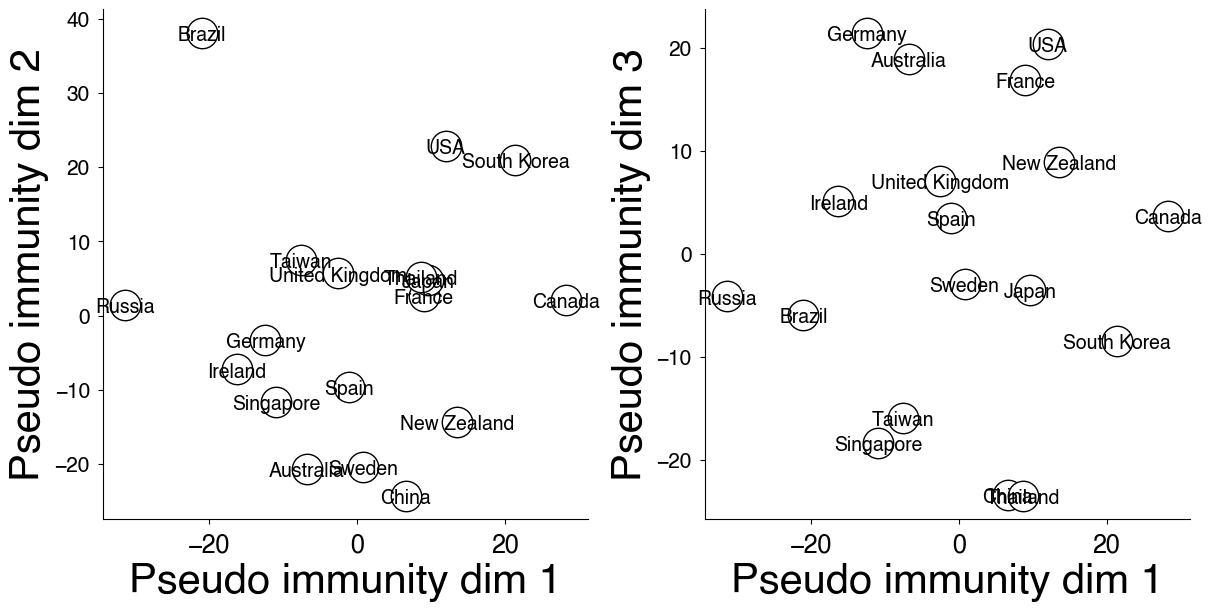

In [43]:
# Embed by location
phi = posterior.samples["phi"][0, :, :-1, :] # Remove other
phi_scaled = (phi - phi.mean(axis=0)) / np.std(phi, axis=0)
phi_scaled = jnp.reshape(phi_scaled, (-1, len(posterior.data.names)) )
phi_transformed = mds.fit_transform(phi_scaled.T)
    
def _plot_mds_location(ax, dim_1, dim_2):
    ax.scatter(phi_transformed[:,dim_1], phi_transformed[:,dim_2], 
                   ec="k", 
                   color="white",
                   s=480)
    ax.set_xlabel(f"Pseudo immunity dim {dim_1+1}")
    ax.set_ylabel(f"Pseudo immunity dim {dim_2+1}")   
                
    # Add names to locations
    for i, txt in enumerate(posterior.data.names):
        ax.annotate(txt, (phi_transformed[i,dim_1], phi_transformed[i,dim_2]), rotation=0, size=14, weight="bold", ha='center', va="center_baseline")
    return None
    
fig = plt.figure(figsize=(12., 6.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=1)

ax = fig.add_subplot(spec[0])
_plot_mds_location(ax, 0, 1)

ax = fig.add_subplot(spec[1])
_plot_mds_location(ax, 0, 2)

In [44]:
def create_titer_distance_df(X):
    rows = []
    for i, v in enumerate(X.columns):
        for j, u in enumerate(X.columns[:(i+1)]):
            rows.append({"variant_1": v, "variant_2": u, "titer_distance": distances[i, j]})
    return pd.DataFrame(rows)

distances_dfs = []
for name, group in antigenic_map.groupby("group"):
    X = group.drop(columns=["id", "group"])
    distances = compute_log2_distances(X)
    _distance_df = create_titer_distance_df(X)
    _distance_df["group"] = name
    distances_dfs.append(_distance_df)

distances_dfs = pd.concat(distances_dfs)

In [45]:
antigenic_map

id                           group  D614G  Beta  BA.1  BA.2  \
0       JN.1-36  BA.5/BF.7 BTI + JN.1 infection   1381   714  2235  8310   
1       JN.1-49  BA.5/BF.7 BTI + JN.1 infection    463   671  1042   829   
2        JN.1-2  BA.5/BF.7 BTI + JN.1 infection   4862  1122  2805  7525   
3        JN.1-5  BA.5/BF.7 BTI + JN.1 infection    310   256  1425  2028   
4       JN.1-52  BA.5/BF.7 BTI + JN.1 infection    577   568  1220   699   
..          ...                             ...    ...   ...   ...   ...   
23        VAC26                      WT vaccine    438   294   114    88   
24  BA.5.2-61nv                  BA.5 infection     20    20    20   214   
25  BA.5.2-60nv                  BA.5 infection     20    20    20   146   
26  BA.5.2-43nv                  BA.5 infection     34    28    30   184   
27  BA.5.2-26nv                  BA.5 infection     20    20    20    54   

    BA.2.75  CH.1.1  BA.5.2  BA.5.2.1  ...  EG.5.1  HV.1  HK.3  JD.1.1  JG.3  \
0      2671     559    4119      2680  ...     327   475   250     170   245   
1       537     135    2103       544  ...     271   445   365     321   200   
2       374     300    3650      2455  ...     485   587   283     175   294   
3       511     273    3710      1799  ...     480   655   243     135   153   
4       639      82    1047       283  ...     203   257   210     173   147   
..      ...     ...     ...       ...  ...     ...   ...   ...     ...   ...   
23      100      20      74        39  ...      20    20    20      20    20   
24       44      27     196       104  ...      26    44    30      22    23   
25       54      26     190       110  ...      42    48    20      20    20   
26       80      33     202       144  ...      28    40    26      20    22   
27       54      20      76        50  ...      20    20    20      20    20   

    BA.2.86.1  JN.1  BA.2.87.1  JN.1.23  KP.3  
0        1072   939        195      461   399  
1         735   284        107      257   146  
2        1410   866        455      411   252  
3         801   771        151      359   395  
4         380   259         65      222   188  
..        ...   ...        ...      ...   ...  
23         31    27         20       28    20  
24         20    20         20       20    20  
25         72    62         20       48    20  
26         86    48         26       34    20  
27         42    31         20       29    20  

[68 rows x 22 columns]

/var/folders/27/fy80dyf90h520912n_x6g8nm0000gn/T/ipykernel_66249/3634135950.py:60: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


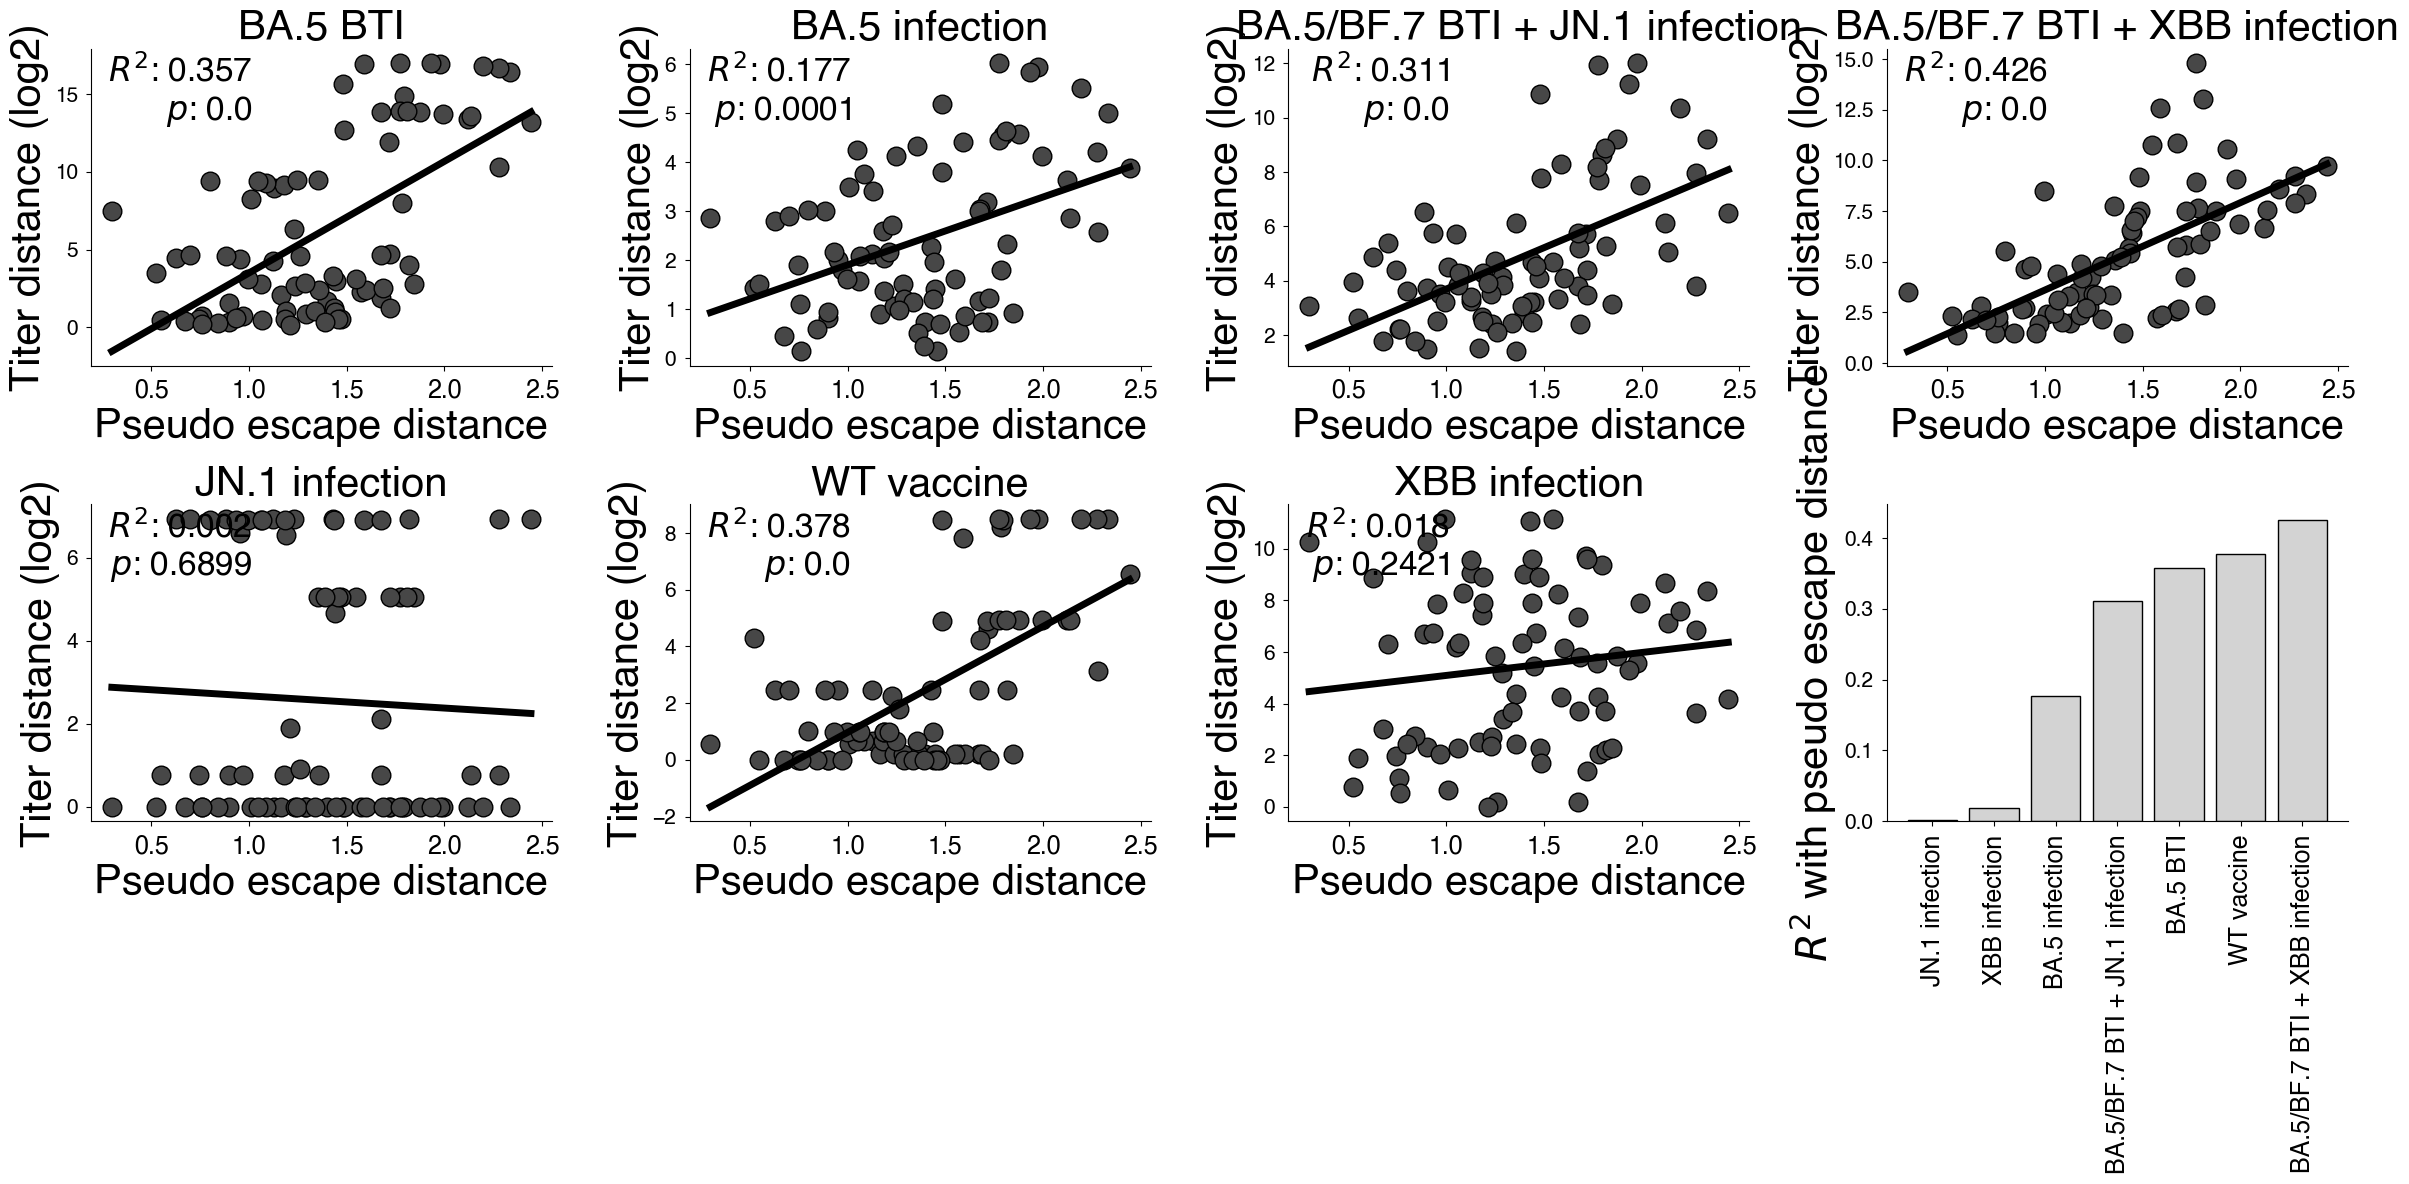

In [46]:
fig = plt.figure(figsize=(24., 12.), constrained_layout=True)
spec = fig.add_gridspec(2,4)

## Prepping data and labels
eta = posterior.samples["eta"][0, :-1, :] # Remove other
n_vars, n_comps = eta.shape

eta_distances = jnp.sqrt(jnp.sum(jnp.square(eta[..., None] - eta.T), axis=1))
var_names = posterior.data.var_names
var_to_index = {v: i for i, v in enumerate(var_names)}        

def add_latent_distance(row):
    if row["variant_1"] in common_variants and row["variant_2"] in common_variants:
        return float(eta_distances[var_to_index[row["variant_1"]], var_to_index[row["variant_2"]]])
    else:
        return np.nan
distances_dfs["latent_distance"] = distances_dfs.apply(add_latent_distance, axis=1)
distances_dfs = distances_dfs[distances_dfs.variant_1 != distances_dfs.variant_2]

# Fit linear regression
def fit_linear(df, col1, col2):
    x, y = df[col1], df[col2]
    is_finite = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[is_finite], y[is_finite]
    slope, intercept, r, p, se = stats.linregress(x, y)      
    xs = np.linspace(np.min(x), np.max(x), 20)
    ys = intercept + slope * xs
    return xs, ys, r, p

correlation_df = []
for i, (name, group) in enumerate(distances_dfs.groupby("group")):
    ax = fig.add_subplot(spec[i])
    x_col, y_col =  "latent_distance", "titer_distance"
    x, y = group[x_col], group[y_col]
    ax.scatter(x, y, ec="k", color="#474747", s=180)            

    # Fit linear regression between two variables
    xs, ys, r, p = fit_linear(group, x_col, y_col)
    ax.plot(xs, ys, color="k")

    # Add regression statistics
    stats_text = r'$R^2$: ' + str((r ** 2).round(3)) +"\n" r"$p$: " + str(p.round(4))
    ax.text(0.35, 0.985, stats_text,
            horizontalalignment='right',
            verticalalignment='top',
            transform=ax.transAxes, fontsize=24)
    ax.set_xlabel("Pseudo escape distance")
    ax.set_ylabel("Titer distance (log2)")
    ax.set_title(name)
    
    correlation_df.append({"group": name, "R2": r ** 2})
    
correlation_df = pd.DataFrame(correlation_df).sort_values(by="R2")

ax = fig.add_subplot(spec[-1])
ax.bar(correlation_df.group, correlation_df.R2, ec="k", color="lightgrey")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel(r"$R^2$ with pseudo escape distance")
fig.tight_layout()

fig.savefig("../manuscript/supplementary_figures/titer_pseudo_escape_distance_by_group.png")

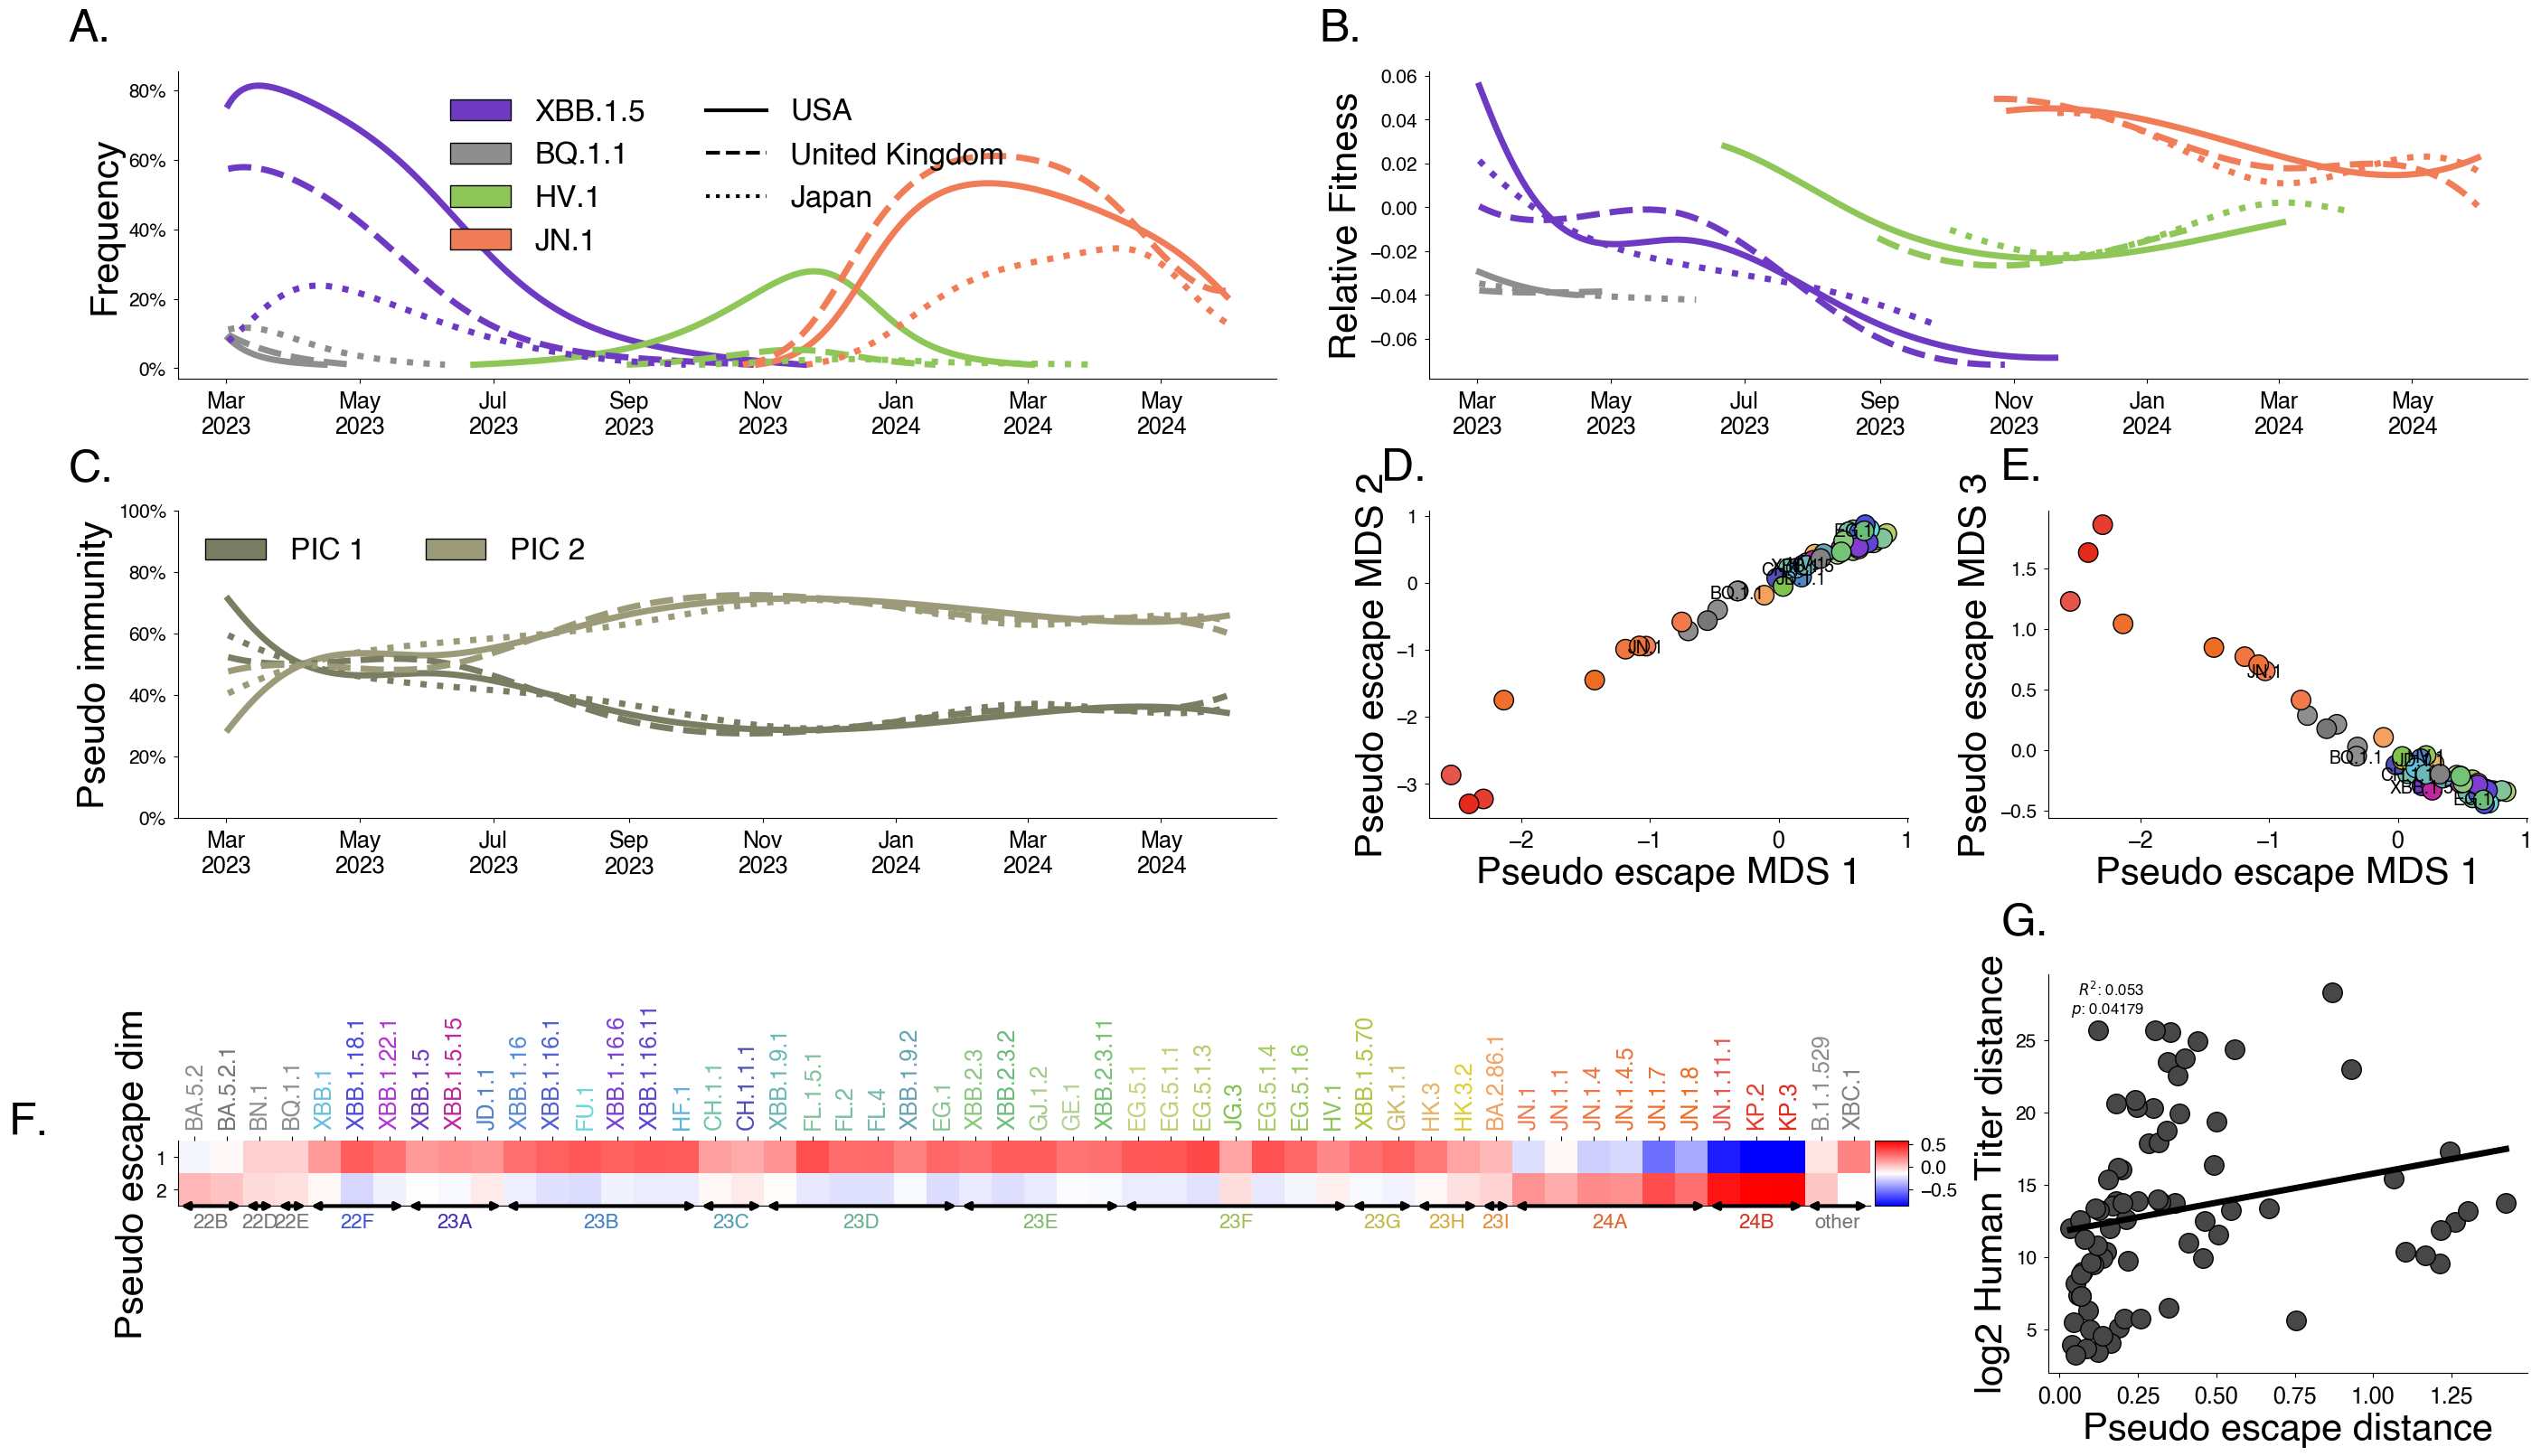

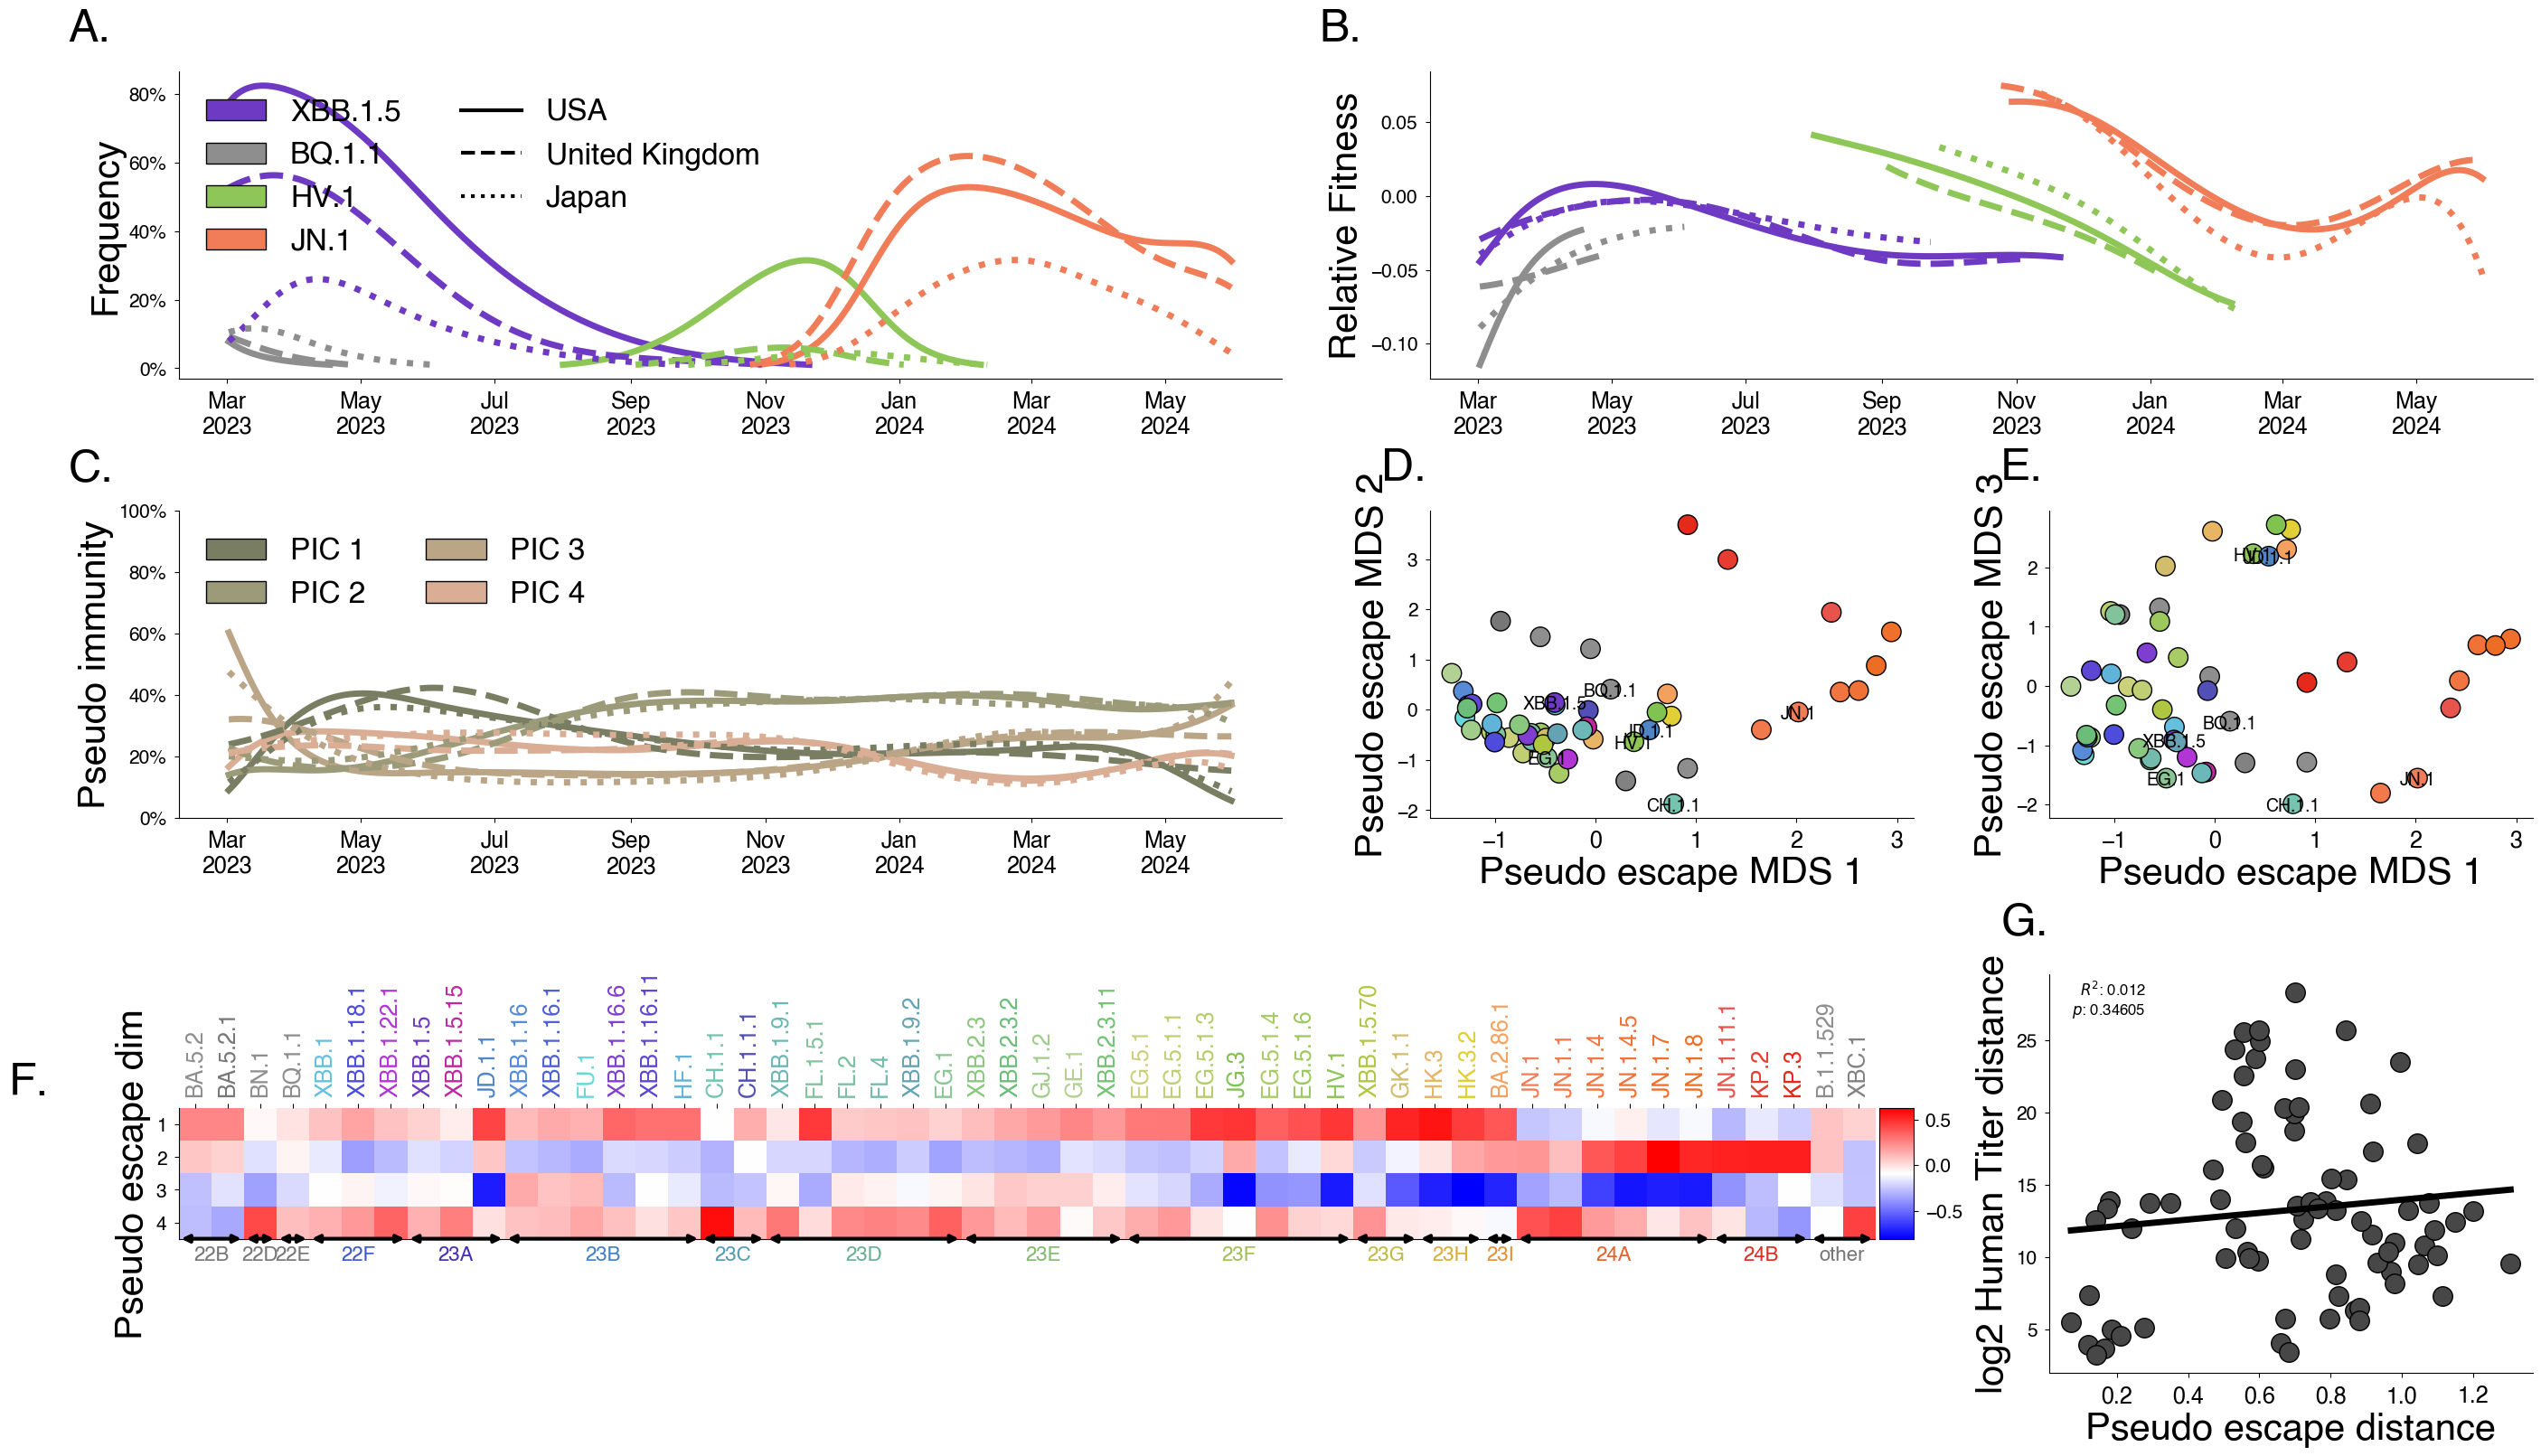

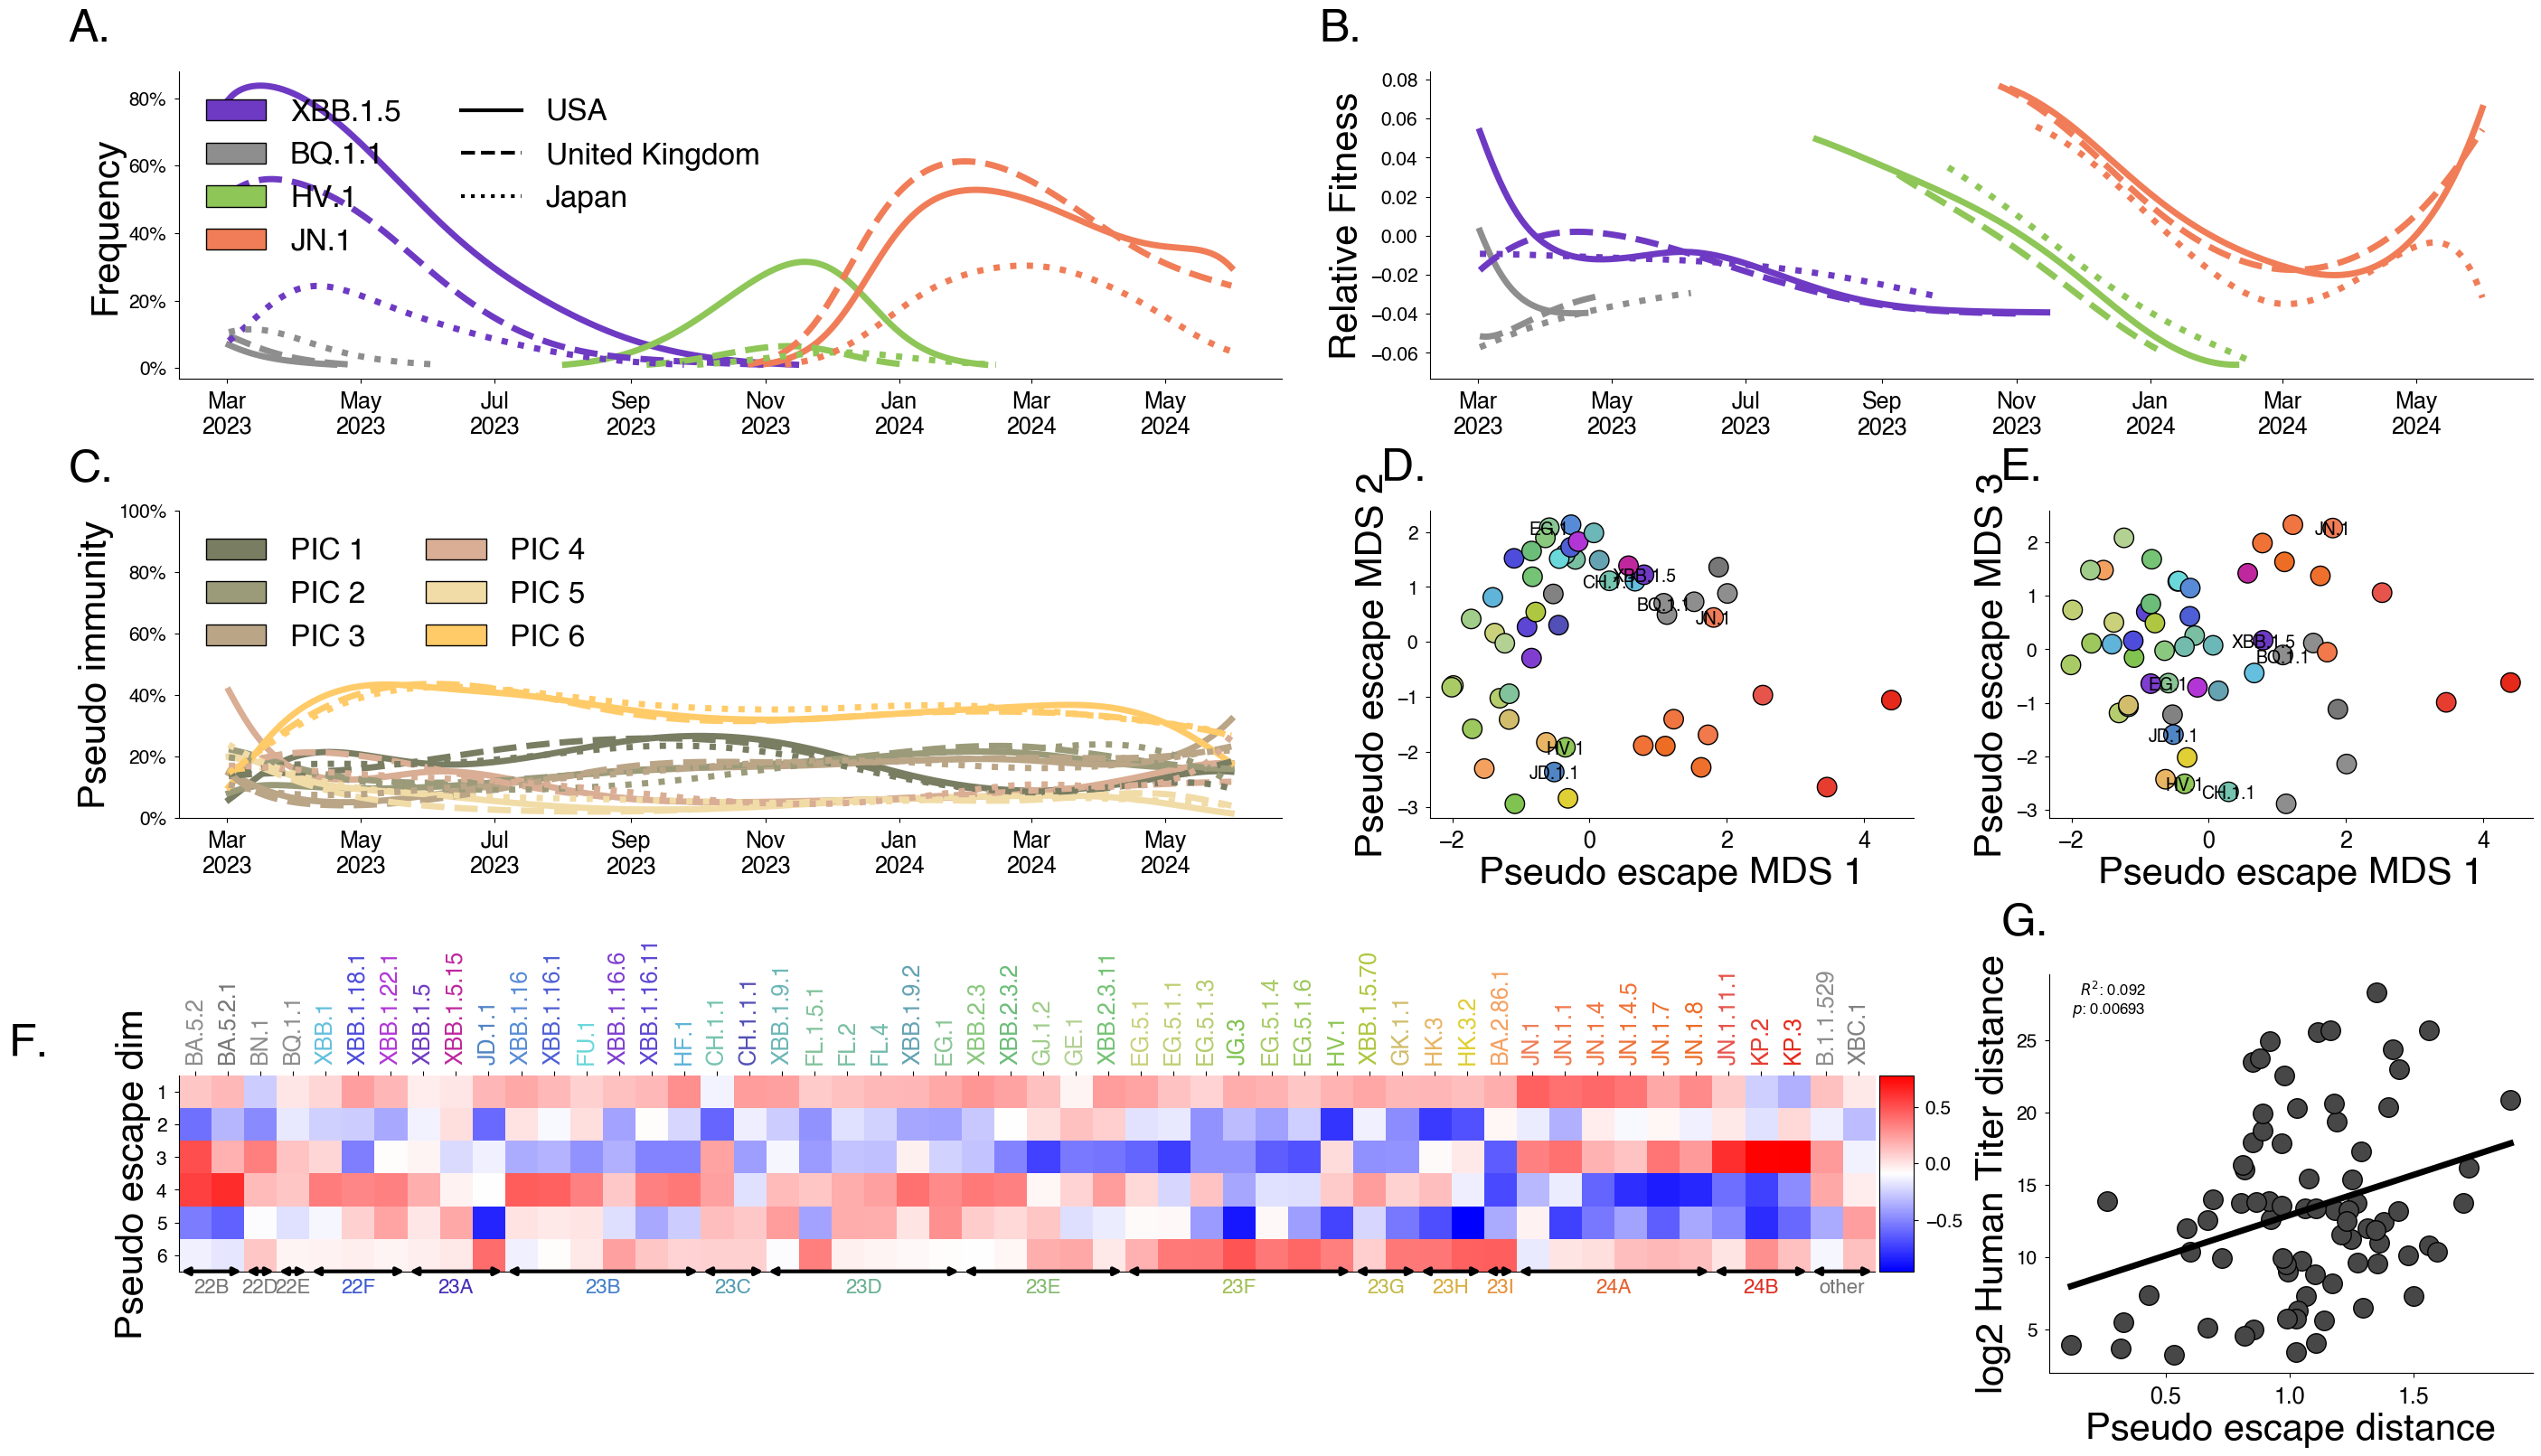

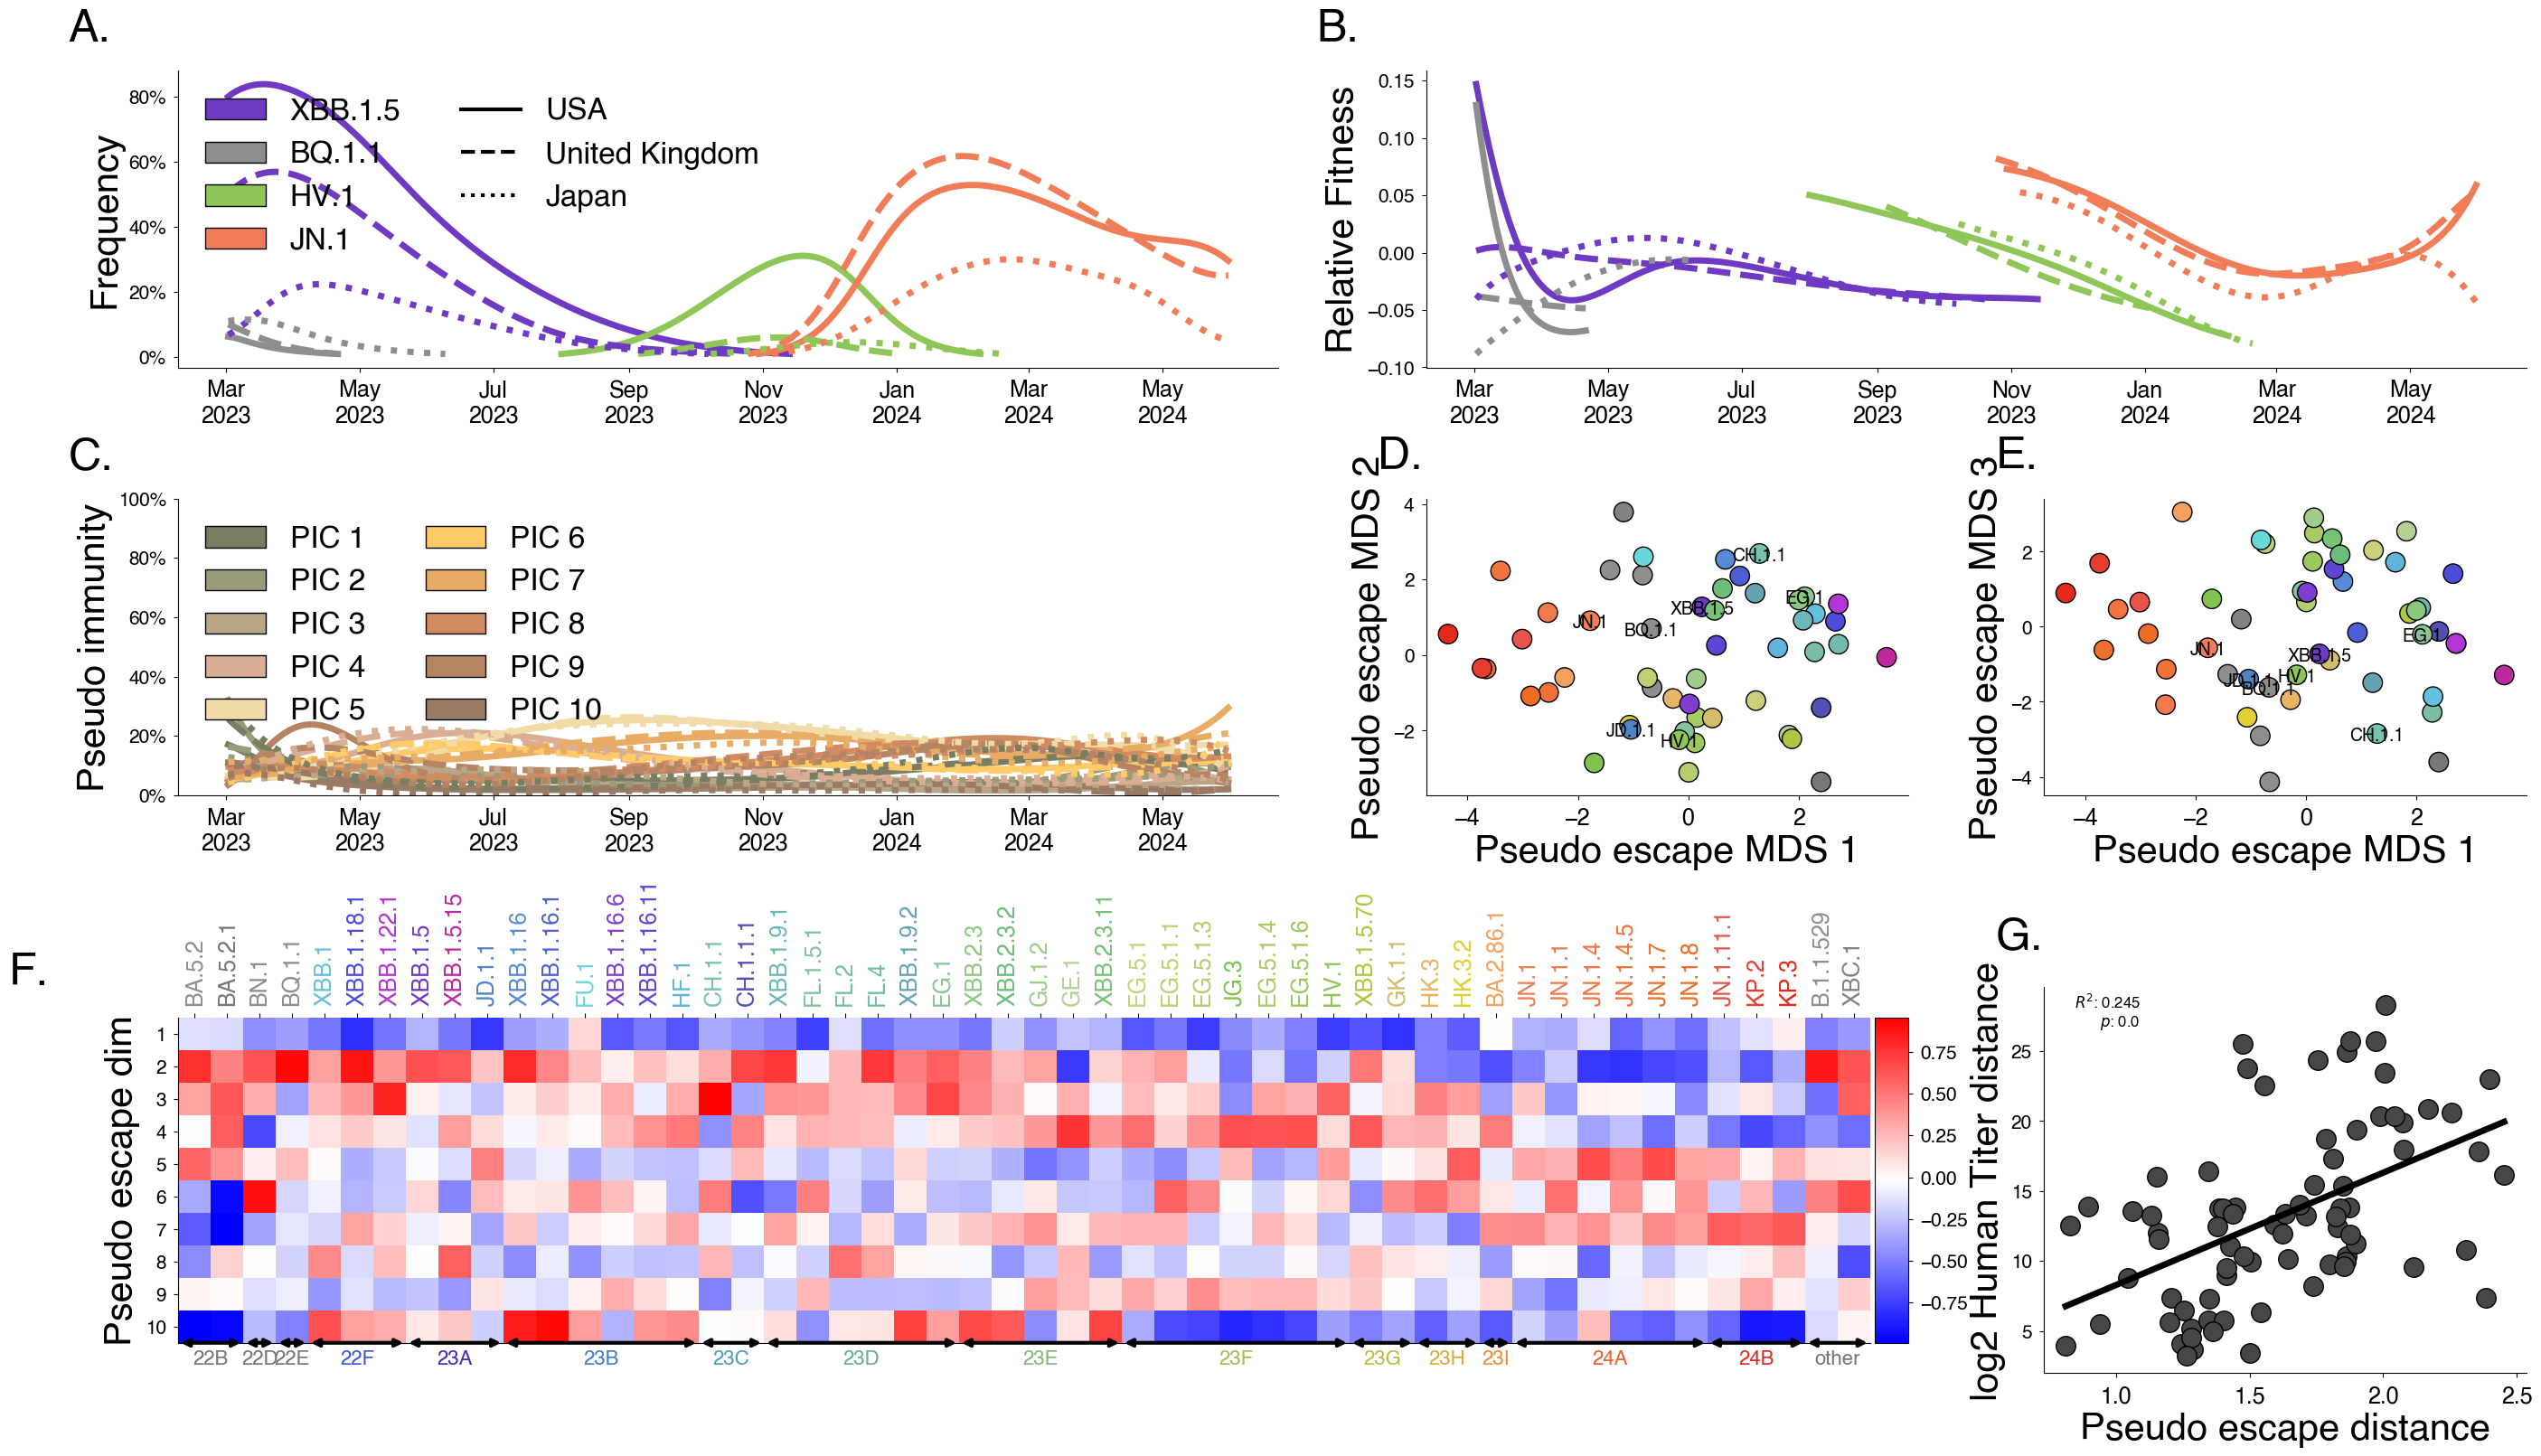

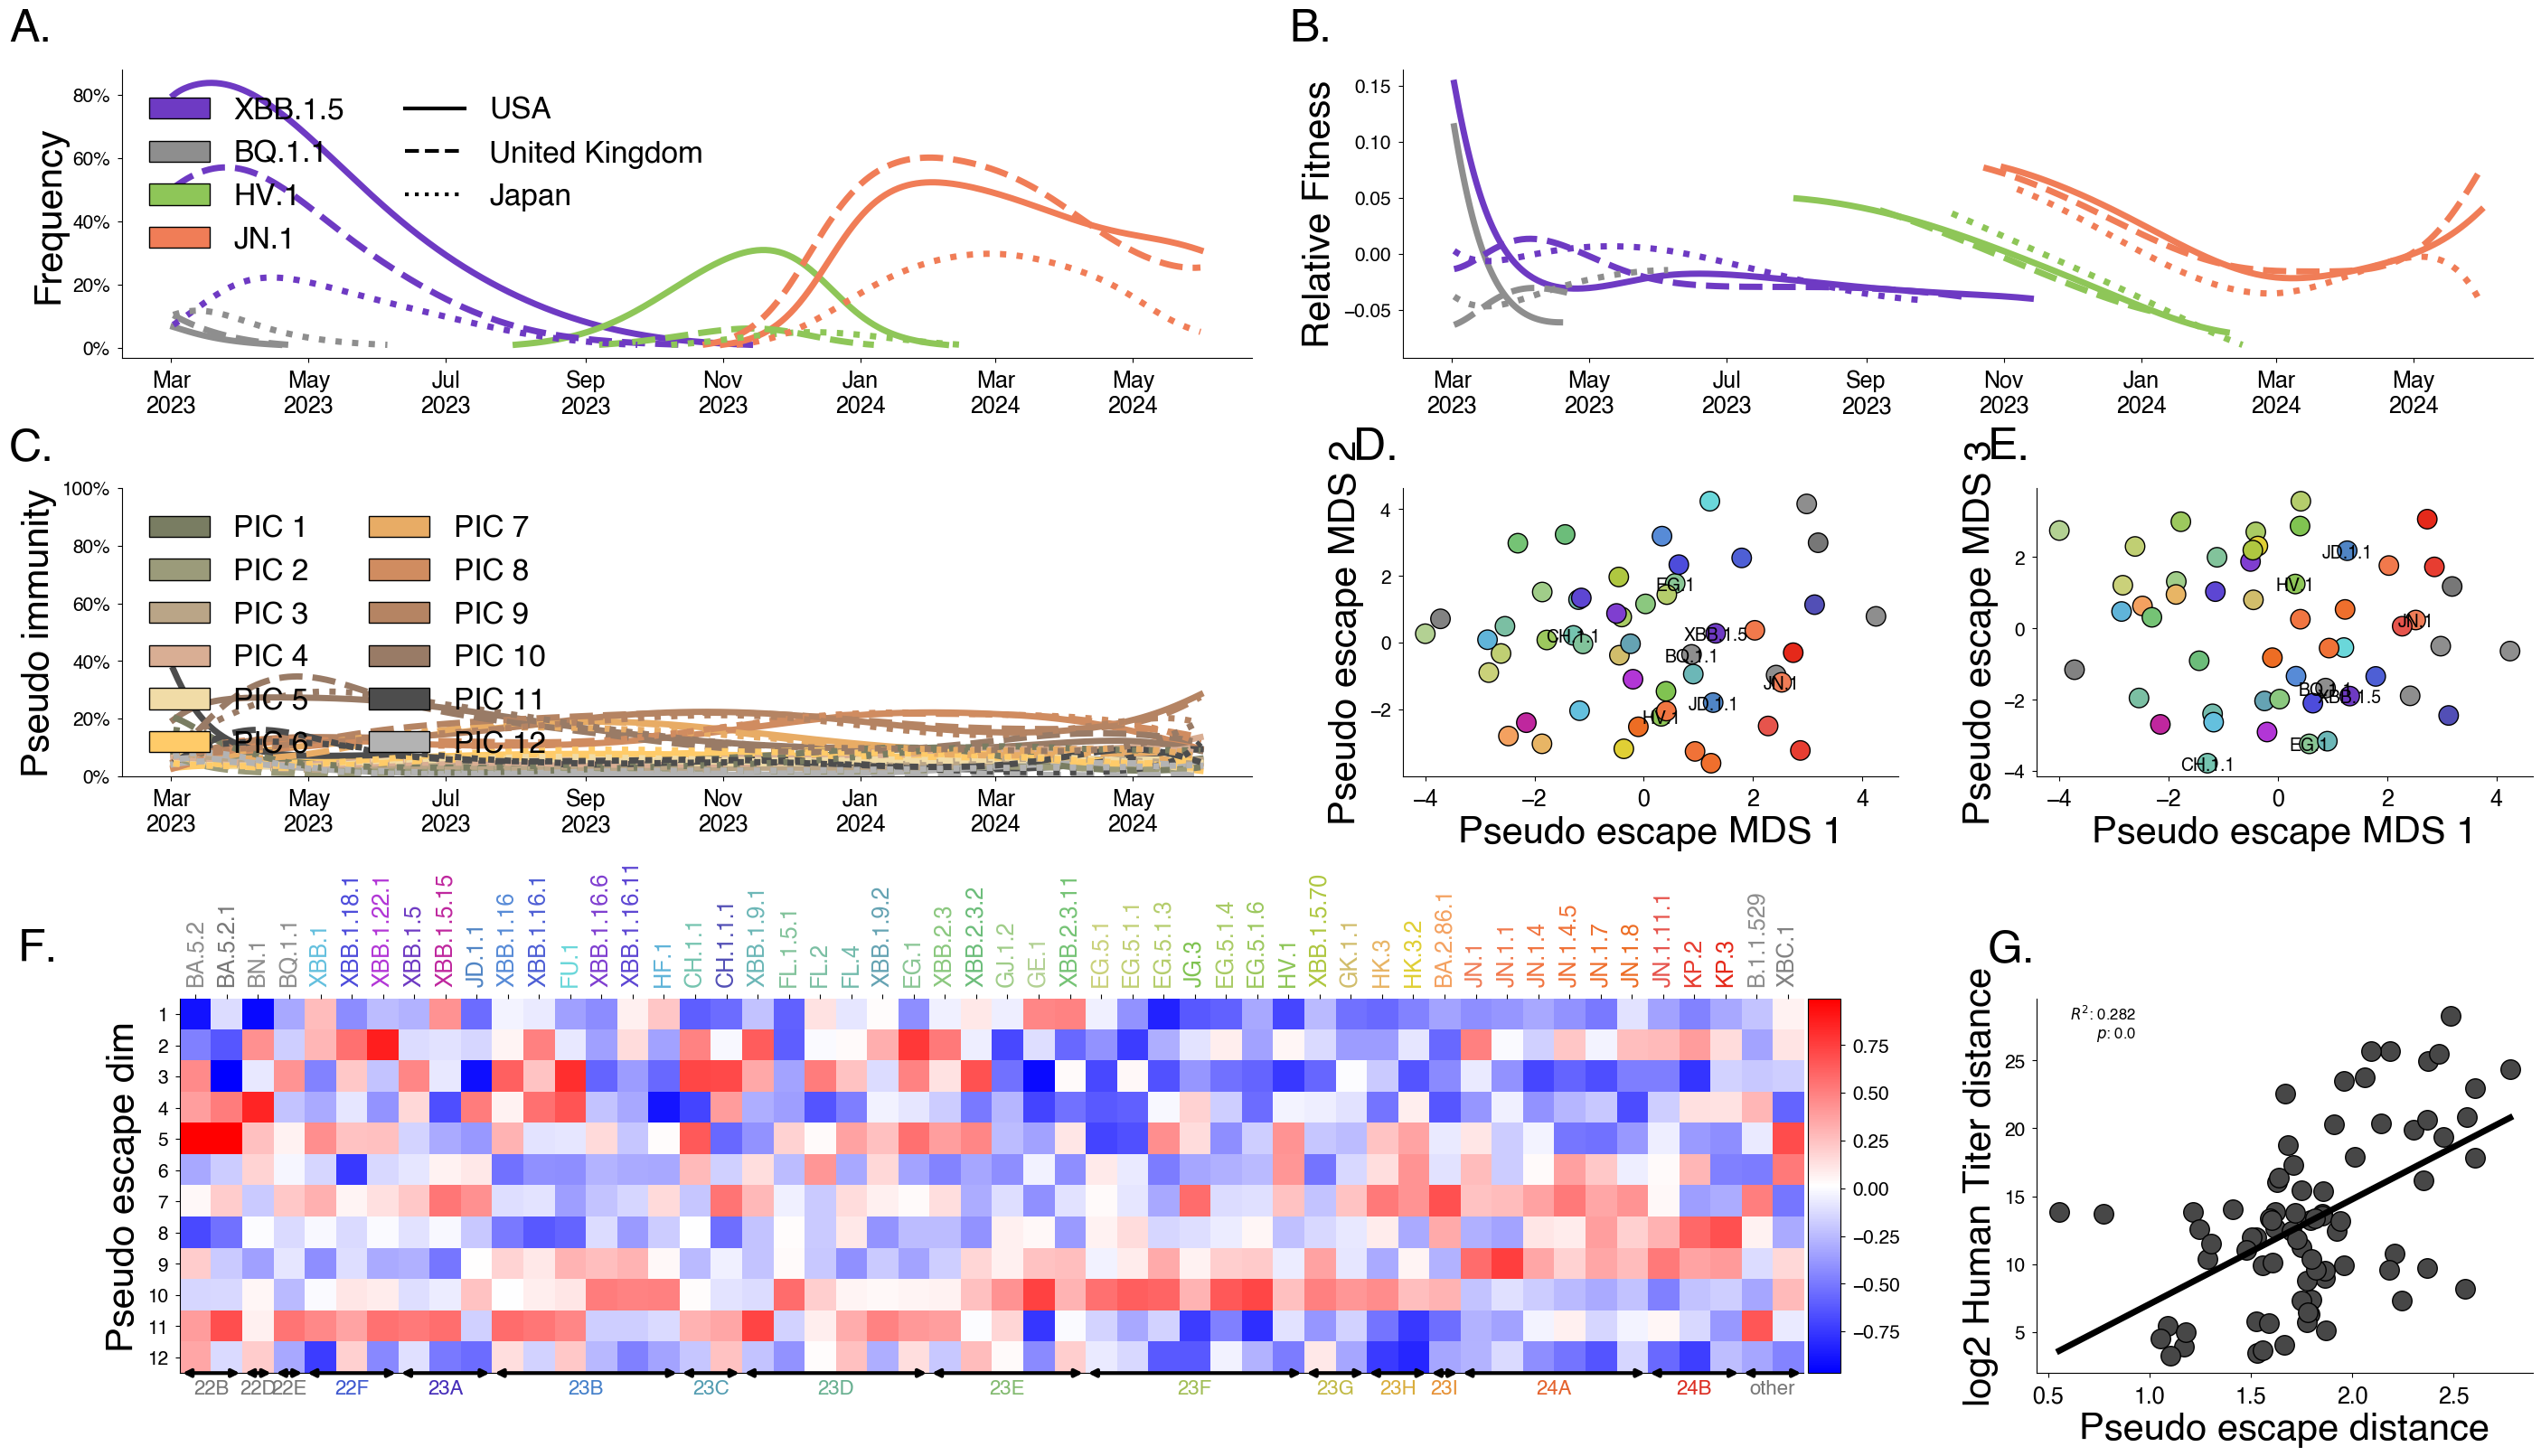

In [47]:
# Replicates for main figure for selected K
# Merge in latent distnances
def add_latent_distance(row, var_to_index, eta_distances):
    if row["variant_1"] in common_variants and row["variant_2"] in common_variants:
        return float(eta_distances[var_to_index[row["variant_1"]], var_to_index[row["variant_2"]]])
    else:
        return np.nan
    
# Fit linear regression
def fit_linear(col1, col2):
    x, y = distances_df[col1], distances_df[col2]
    is_finite = ~np.isnan(x) & ~np.isnan(y)
    x, y = x[is_finite], y[is_finite]
    slope, intercept, r, p, se = stats.linregress(x, y)      
    xs = np.linspace(np.min(x), np.max(x), 20)
    ys = intercept + slope * xs
    return xs, ys, r, p

for latent_dim in latent_dim_candidates[::2]:
    if latent_dim == chosen_latent:
        continue
    fig = summary_plot_hier(posteriors[latent_dim], color_map, freq_thres=0.01, 
                        focal_variants=["XBB.1.5", "BQ.1.1", "HV.1", "JN.1"],
                        label_variants=["XBB.1.5", "CH.1.1", "BQ.1.1", "JD.1.1", "EG.1", "HV.1", "JN.1"],
                        plot_eta_time_mean=False
                       )
    fig.savefig("../manuscript/supplementary_figures/" + f"latent_immune_{latent_dim}_dims.png")

In [48]:
latent_dim_candidates[::2]

array([ 2,  4,  6,  8, 10, 12])

In [49]:

def bootstrap_regression(n_bootstrap, distance_df):
    x_col, y_col =  "latent_distance", "titer_distance"
    
    r2s = []
    ps = []
    expected = []
    
    def fit_linear(col1, col2):
        x, y = distance_df[col1], distance_df[col2]
        is_finite = ~np.isnan(x) & ~np.isnan(y)
        
        # Boostrap for present data
        n_finite = np.sum(is_finite)
        sample = np.random.choice(n_finite, n_finite, replace=True)
                
        # Fit regression
        x, y = x[is_finite].values[sample], y[is_finite].values[sample]
        slope, intercept, r, p, se = stats.linregress(x, y)      
        xs = np.linspace(np.min(x), np.max(x), 20)
        ys = intercept + slope * xs
        return xs, ys, r, p

    
    for _ in range(n_bootstrap):
        # Fit linear regression
        xs, ys, r, p = fit_linear(x_col, y_col) 
        
        expected.append((xs,ys))
        r2s.append(r)
        ps.append(p)
    return r2s, ps, expected

# Compute base distance df
X = antigenic_map.drop(columns=["id", "group"])
distances = compute_log2_distances(X)
distances_df = create_titer_distance_df(X)
distances_df = distances_df[distances_df.variant_1 != distances_df.variant_2]

dfs = {}
r2s = {}
for latent_dim, post in posteriors.items():
    dfs[latent_dim] = get_and_add_distances(post, distances_df)
    r2s[latent_dim], _, _ = bootstrap_regression(1_000,  dfs[latent_dim])

In [50]:
(dfs[2] == dfs[5])["latent_distance"].mean()

0.0

In [51]:
dfs[2][~pd.isna(dfs[2].latent_distance)].variant_1.unique()

array(['BA.5.2', 'BA.5.2.1', 'BQ.1.1', 'XBB.1.5', 'EG.5.1', 'HV.1',
       'HK.3', 'JD.1.1', 'JG.3', 'BA.2.86.1', 'JN.1', 'KP.3'],
      dtype=object)

/var/folders/27/fy80dyf90h520912n_x6g8nm0000gn/T/ipykernel_66249/110307185.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(list(r2s.values()), labels=list(r2s.keys()))


Text(0, 0.5, '$R^2$\nPseudo-immune and titer distance')

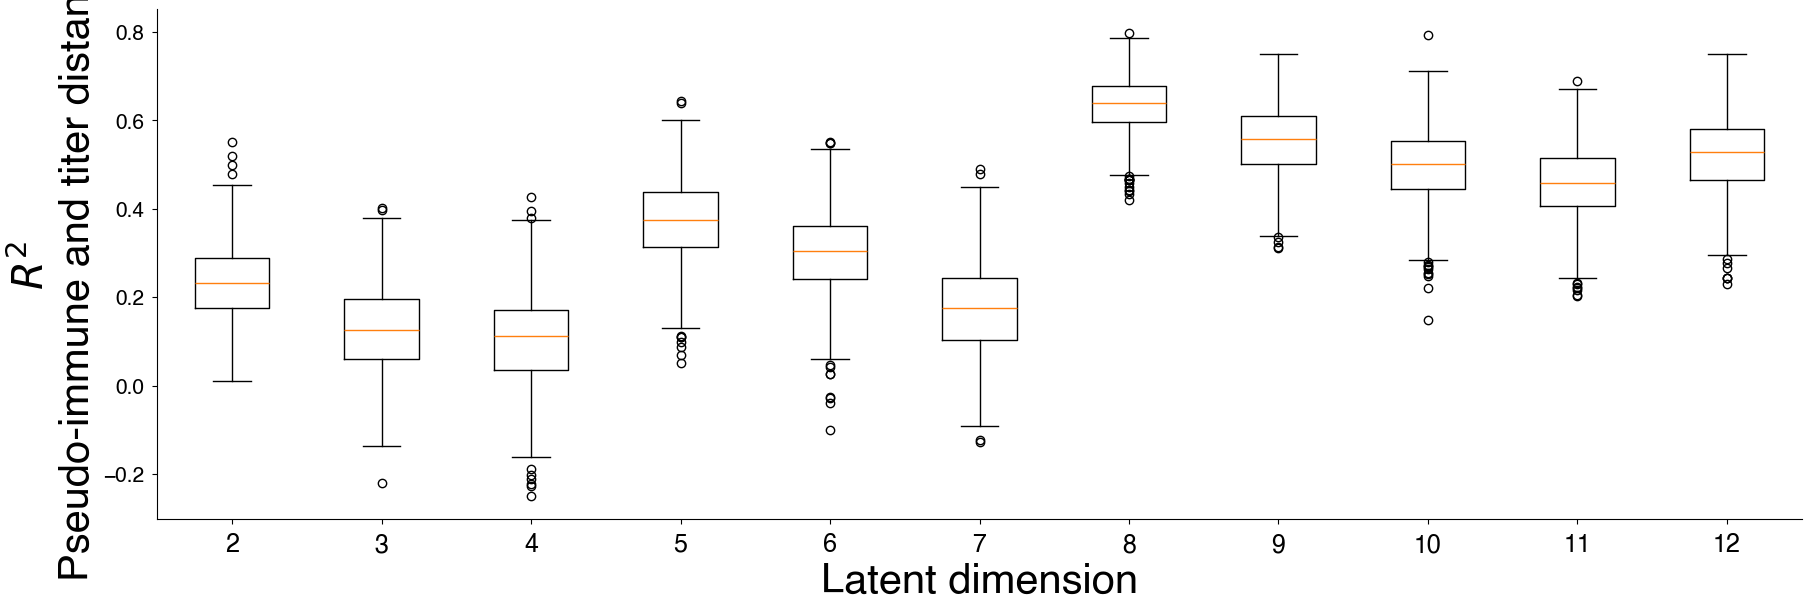

In [52]:
fig = plt.figure(figsize=(18., 6.), constrained_layout=True)
spec = fig.add_gridspec(1,1)
ax = fig.add_subplot(spec[0])

ax.boxplot(list(r2s.values()), labels=list(r2s.keys()))
ax.set_xlabel("Latent dimension")
ax.set_ylabel(r"$R^2$" + "\nPseudo-immune and titer distance")

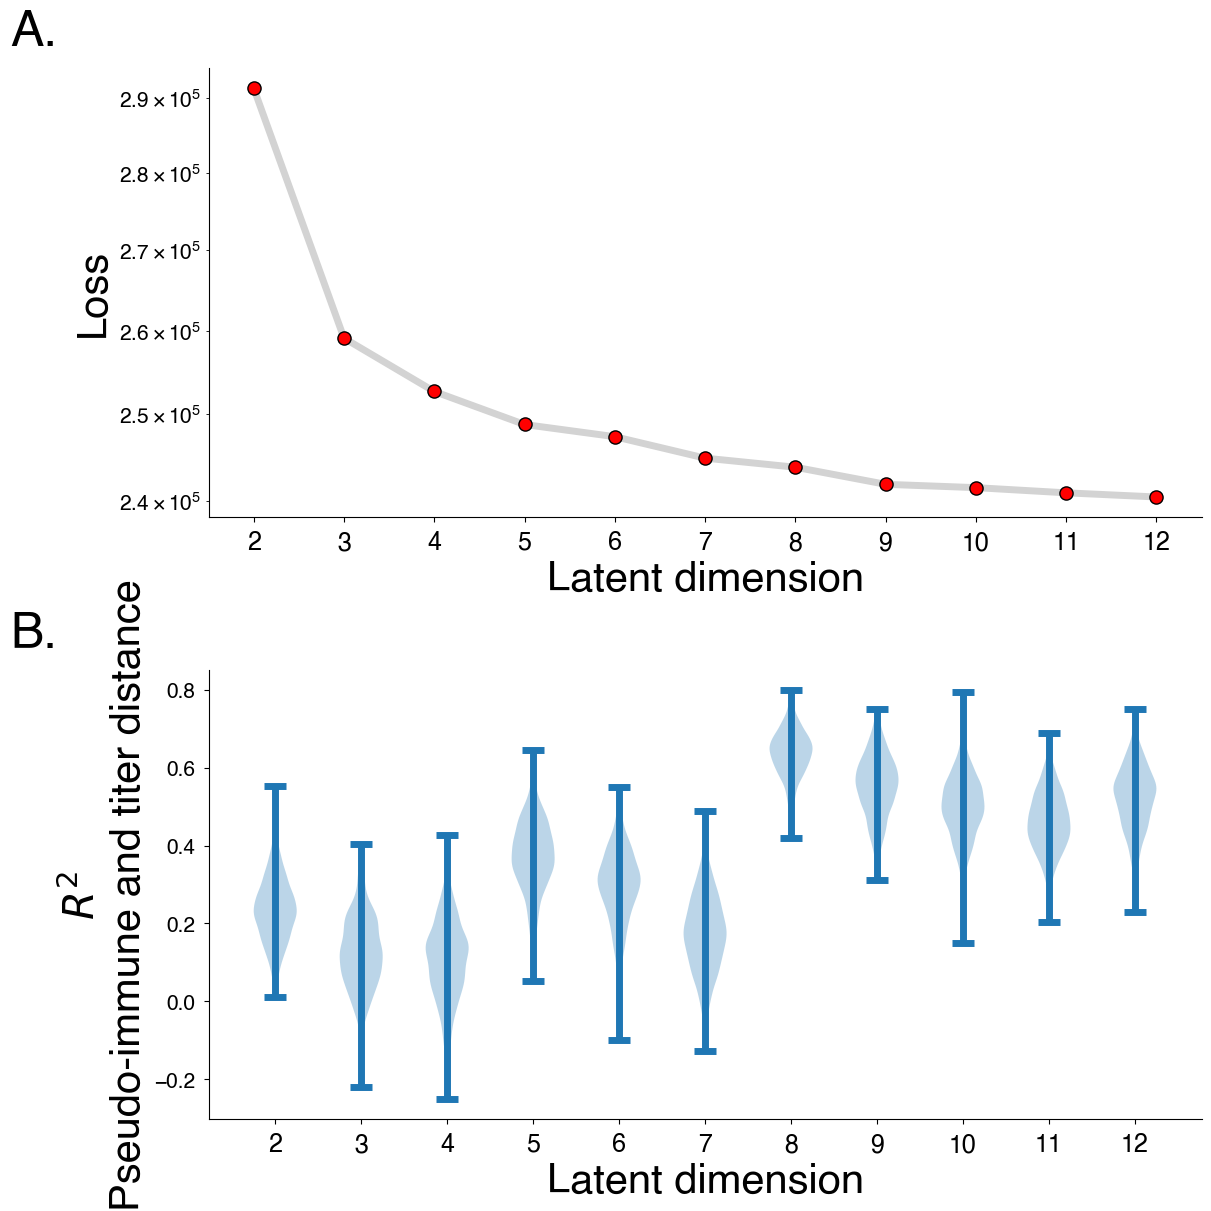

In [53]:
fig = plt.figure(figsize=(12., 12.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=2)

axes = []

ax = fig.add_subplot(spec[0]); axes.append(ax)
losses = {dim: post.samples["losses"][-1] for dim, post in posteriors.items()}
ax.plot(losses.keys(), losses.values(), zorder=-1, color="lightgrey")
ax.scatter(losses.keys(), losses.values(), ec="k", s=90, color="red")
ax.set_yscale("log")
ax.set_ylabel("Loss")
ax.set_xlabel("Latent dimension")
ax.set_xticks(latent_dim_candidates)
 
# Violin plot
ax = fig.add_subplot(spec[1]); axes.append(ax)
ax.violinplot(list(r2s.values()), list(r2s.keys()))
ax.set_xlabel("Latent dimension")
ax.set_ylabel(r"$R^2$" + "\nPseudo-immune and titer distance")
ax.set_xticks(latent_dim_candidates)


ax_labels = ["A", "B", "C", "F", "D", "E", "G"] 

for ax, ax_label in zip(axes, ax_labels):
    ax.text(-0.2, 1.05, ax_label + ".", transform=ax.transAxes, size=36, weight='bold')

#fig.savefig("../manuscript/supplementary_figures/loss_by_latent_dimension.png")

In [54]:
def get_parameter_count(posterior):
    essential_sites = ['_phi_0_base', '_phi_0_rest', 'phi_rw_step', '_init_logit', '_eta']
    parameter_count = 0
    for site in essential_sites:
        parameter_count += posterior.samples[site][0].size
    return parameter_count

In [55]:
num_bases = posteriors[2].samples["phi_rw_step"].shape[1]

In [56]:
#def guess_count(D): 
#    eta_count = (len(unique_variants) - 1) * D 
#    phi_count = len(unique_locations) * D  *  num_bases
#    logit_count = len(unique_locations) * (len(unique_variants)-1)
#    return eta_count + phi_count + logit_count
    
#guessed_count = [guess_count(D) for D in latent_dim_candidates]
parameter_count = [get_parameter_count(posteriors[D]) for D in latent_dim_candidates]

In [57]:
def mlr_fixed_count():
    fitness_count = len(unique_locations) * (len(unique_variants)-1)
    logit_count = len(unique_locations) * (len(unique_variants)-1)
    return fitness_count + logit_count

def mlr_time_count():
    fitness_count = len(unique_locations) * (len(unique_variants)-1) * num_bases
    logit_count = len(unique_locations) * (len(unique_variants)-1)
    return fitness_count + logit_count

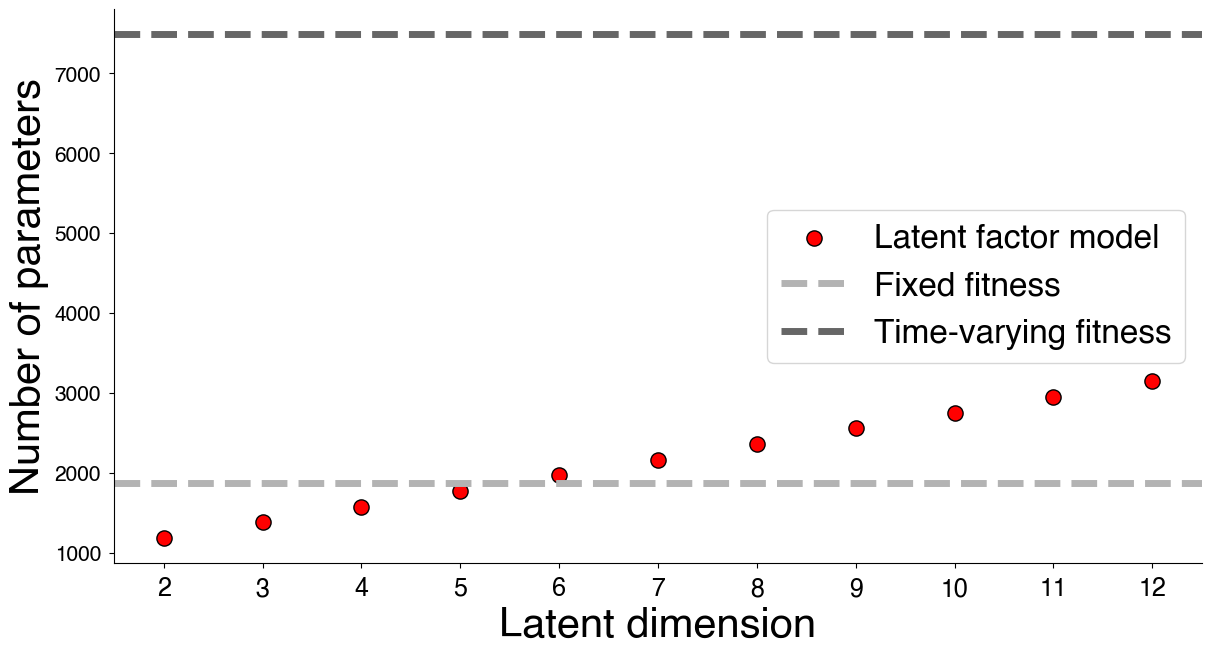

In [58]:
fig = plt.figure(figsize=(12., 12.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=2)
ax = fig.add_subplot(spec[0])
#ax.plot(latent_dim_candidates, parameter_count, zorder=-1, color="lightgrey")
ax.scatter(latent_dim_candidates, parameter_count, color="red", ec="k", s=120, label="Latent factor model")
ax.axhline(mlr_fixed_count(),linestyle="--", color="#B3B3B3", label="Fixed fitness")
ax.axhline(mlr_time_count(),linestyle="--", color="#666666", label="Time-varying fitness")
ax.set_ylabel("Number of parameters")
ax.set_xlabel("Latent dimension")
ax.set_xticks(latent_dim_candidates)
ax.legend()

In [59]:
print(parameter_count[chosen_latent])

2752


In [60]:
def get_bic(posteriors, latent_dim_candidates):
    num_datapoints = posteriors[latent_dim_candidates[0]].data.seq_counts.size
    parameter_counts = [get_parameter_count(posteriors[D]) for D in latent_dim_candidates]
    losses = [-posteriors[D].samples["losses"][-1] for D in latent_dim_candidates] # loss = negative log likelhood
    bic = np.array([float(np.log(num_datapoints) * k  - 2 * l) for k, l in zip(parameter_counts, losses)])
    bic_min = np.min(bic)
    prob_min_information_loss = np.exp((bic_min - bic) / 2)
    
    return bic, prob_min_information_loss

bic, prob_min_information_loss = get_bic(posteriors, latent_dim_candidates)

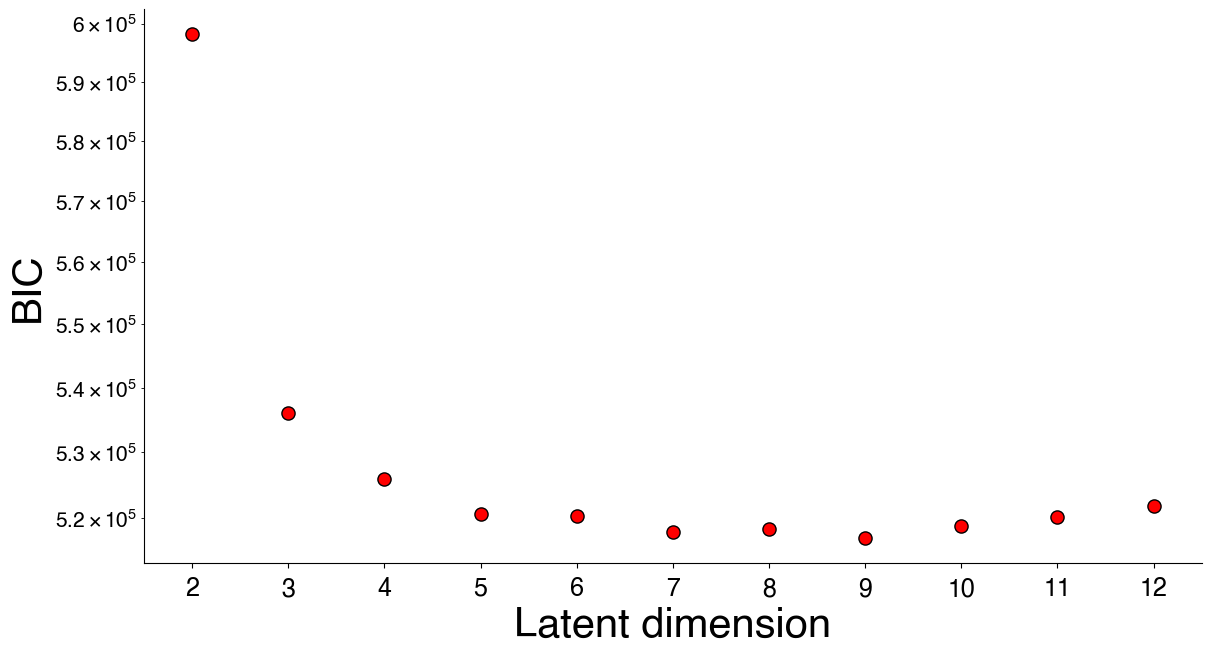

In [61]:
fig = plt.figure(figsize=(12., 12.), constrained_layout=True)
spec = fig.add_gridspec(ncols=1, nrows=2)
ax = fig.add_subplot(spec[0])
ax.scatter(latent_dim_candidates, bic, color="red", ec="k", s=90)
ax.set_ylabel("BIC")
ax.set_xlabel("Latent dimension")
ax.set_xticks(latent_dim_candidates)
ax.set_yscale("log")

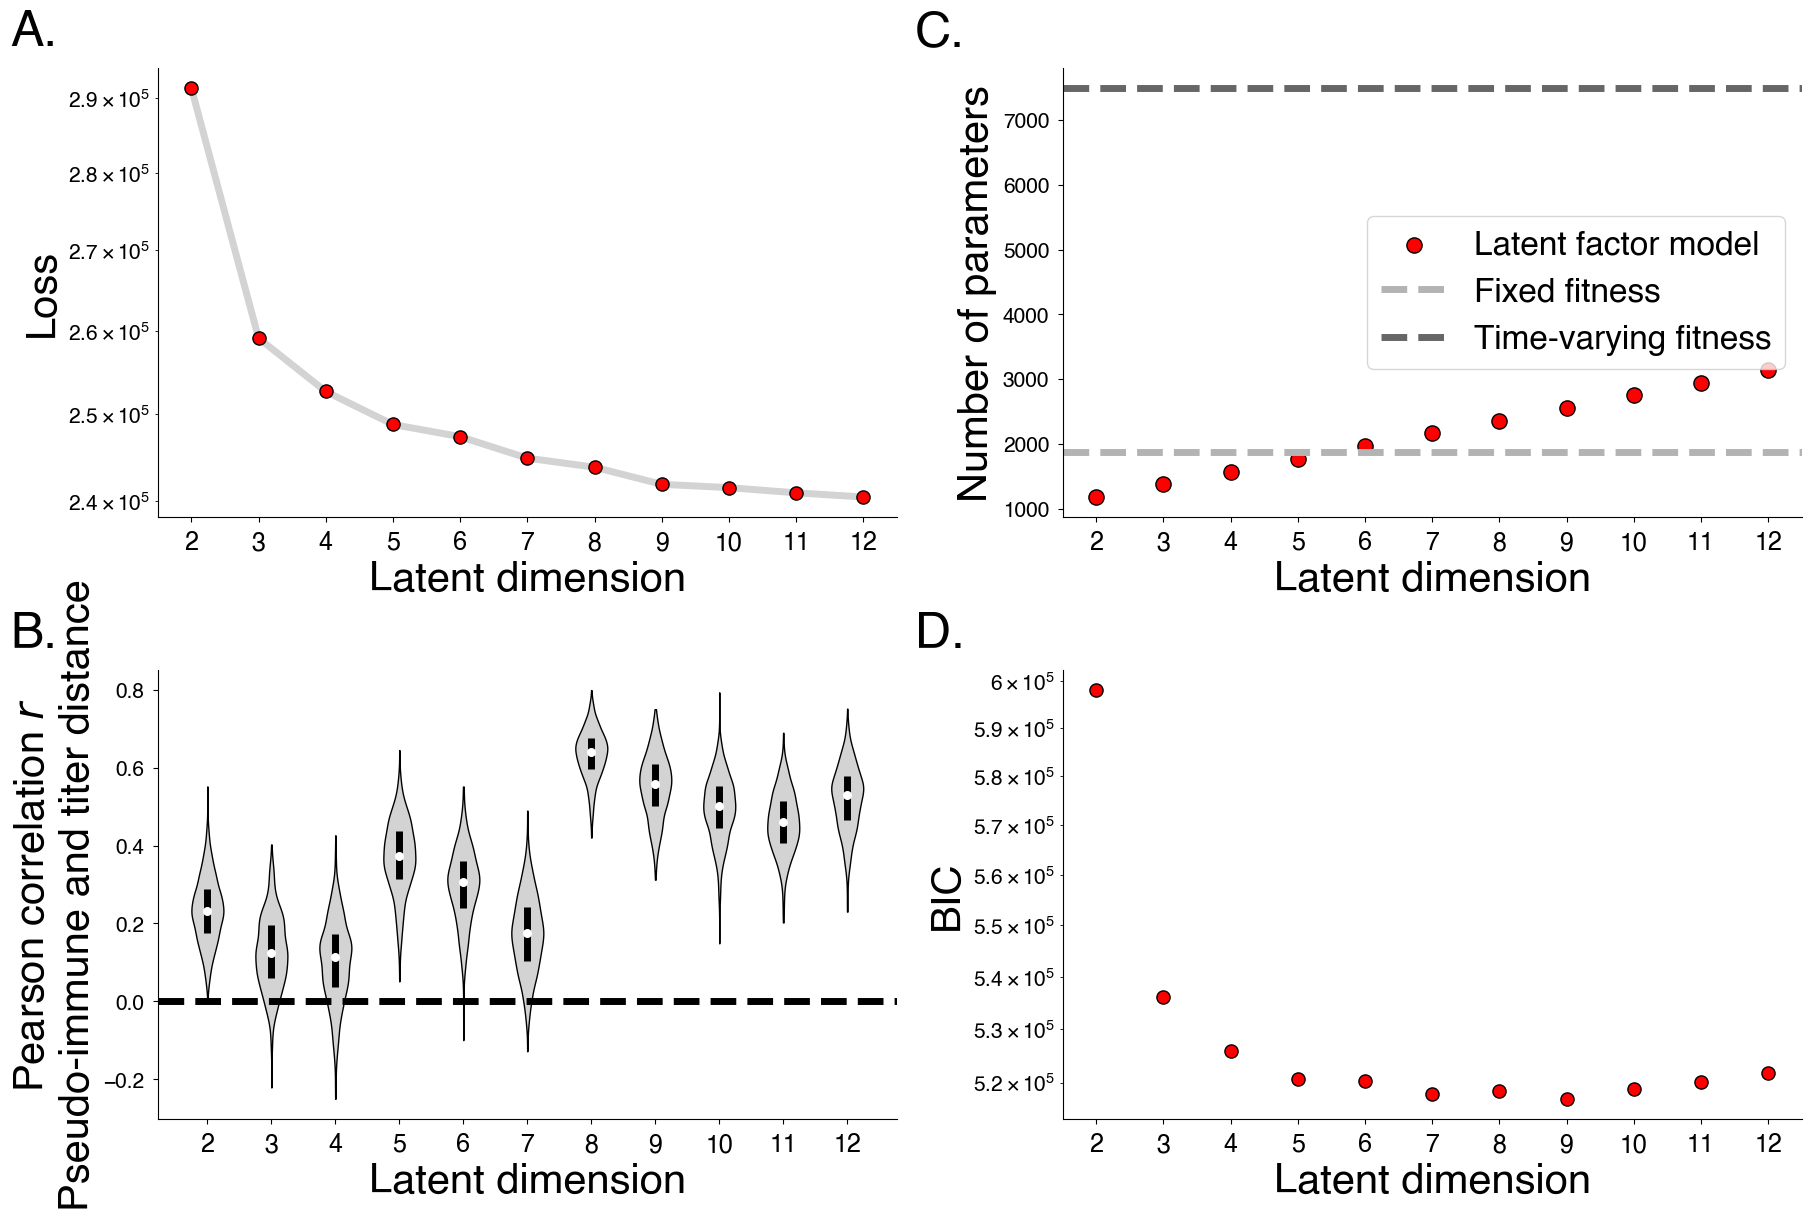

In [62]:
fig = plt.figure(figsize=(18., 12.), constrained_layout=True)
spec = fig.add_gridspec(ncols=2, nrows=2)

axes = []

# Loss by dimension
ax = fig.add_subplot(spec[0]); axes.append(ax)
losses = {dim: post.samples["losses"][-1] for dim, post in posteriors.items()}
ax.plot(losses.keys(), losses.values(), zorder=-1, color="lightgrey")
ax.scatter(losses.keys(), losses.values(), ec="k", s=90, color="red")
ax.set_yscale("log")
ax.set_ylabel("Loss")
ax.set_xlabel("Latent dimension")
ax.set_xticks(latent_dim_candidates)
 
# Violin plot
ax = fig.add_subplot(spec[2]); axes.append(ax)
parts = ax.violinplot(list(r2s.values()), list(r2s.keys()), showmeans=False, showmedians=False,
        showextrema=False)
for pc in parts['bodies']:
    pc.set_facecolor('lightgrey')
    pc.set_edgecolor('black')
    pc.set_alpha(1)
    
quantiles = [np.percentile(r2s[D], [25, 50, 75]) for D in latent_dim_candidates]
ax.scatter(latent_dim_candidates, [q[1] for q in quantiles], marker='o', color='white', s=30, zorder=3)
ax.vlines(latent_dim_candidates, [q[0] for q in quantiles], [q[2] for q in quantiles], color='k', linestyle='-', lw=5)
ax.axhline(y=0.0, color='k', linestyle='--', lw=5)

ax.set_xlabel("Latent dimension")
ax.set_ylabel(r"Pearson correlation $r$" + "\nPseudo-immune and titer distance")
ax.set_xticks(latent_dim_candidates)


# Parameter count
ax = fig.add_subplot(spec[1]); axes.append(ax)
#ax.plot(latent_dim_candidates, parameter_count, zorder=-1, color="lightgrey")
parameter_count = [get_parameter_count(posteriors[D]) for D in latent_dim_candidates]
ax.scatter(latent_dim_candidates, parameter_count, color="red", ec="k", s=120, label="Latent factor model")
ax.axhline(mlr_fixed_count(),linestyle="--", color="#B3B3B3", label="Fixed fitness")
ax.axhline(mlr_time_count(),linestyle="--", color="#666666", label="Time-varying fitness")
ax.set_ylabel("Number of parameters")
ax.set_xlabel("Latent dimension")
ax.set_xticks(latent_dim_candidates)
ax.legend()

# BIC
ax = fig.add_subplot(spec[3]); axes.append(ax)
ax.scatter(latent_dim_candidates, bic, color="red", ec="k", s=90)
ax.set_ylabel("BIC")
ax.set_xlabel("Latent dimension")
ax.set_xticks(latent_dim_candidates)
ax.set_yscale("log")
ax_labels = ["A", "B", "C", "D"] 

for ax, ax_label in zip(axes, ax_labels):
    ax.text(-0.2, 1.05, ax_label + ".", transform=ax.transAxes, size=36, weight='bold')

fig.savefig("../manuscript/supplementary_figures/loss_by_latent_dimension.png")